<a href="https://colab.research.google.com/github/wai-ming-chan/fed_avg/blob/main/FedAvg_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo program to train MNIST with Pytorch (Federated Averging)

Reference: [https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029](https://towardsdatascience.com/preserving-data-privacy-in-deep-learning-part-1-a04894f78029)

In [1]:
###############################
##### importing libraries #####
###############################

import os
import random
from tqdm import tqdm
import numpy as np
import math

import torch, torchvision
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset   
torch.backends.cudnn.benchmark=True

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

#-----------------------------------------------------------------------
# libraries for pyTorch model Visualization
! pip install -q torchview
! pip install -q -U graphviz

# import torchvision

from torchview import draw_graph
from torch import nn
import torch
import graphviz

# when running on VSCode run the below command
# svg format on vscode does not give desired result
graphviz.set_jupyter_format('png')
#-----------------------------------------------------------------------
! pip install -q torch-summary
from torchsummary import summary


### Hyper-parameters setting

In [2]:
class system_args:

    # Set GPU or CPU device. If GPU is available, we use it to speed up the training
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        print('[GPU mode] device: ', device)
    else:
        print('[CPU mode] device: ', device)
    verbose = 1

    num_clients = 100                     # Total number of clients
    num_rounds = 1500                      # number of communication rounds (num of server epoches)
    # bs = 64                               # batch size
    # epochs = 100                          
    lr = 5e-3                             # learning rate
    
    frac_C = 0.1        # C, fraction of clients that perform computation on each round
    local_epoches = 1  # E, number of training passes each client makes over its local dataset on each round
    local_bs = 10       # B, the local minibatch size used for the client updates.
    iid = True          # IID or Non-IID data partition 

    num_selected = math.ceil(frac_C * num_clients)



[GPU mode] device:  cuda


### Helper functions for Federated Training

In [3]:
def client_update(client_model, optimizer, train_loader, system_args):
    model.train()   # tells your model that you are training the model (model.train()	vs model.eval())
    for e in range(system_args.local_epoches):
        for batch_idx, (data, target) in enumerate(train_loader):
            if system_args.device == 'cuda':
                data, target = data.cuda(), target.cuda()
            output = client_model(data)       # make a prediction
            loss = F.cross_entropy(output, target) # compute the loss value
            # loss = F.nll_loss(output, target) # compute the loss value
            # loss = F.nll_loss(output, target) # compute the loss value
            optimizer.zero_grad()             # set our gradient to zero
            loss.backward()                   # gradient descent
            optimizer.step()                  # update our weights and biases
    return loss.item()



def server_aggregate(global_model, client_models, system_args):
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)

    global_model.load_state_dict(global_dict)

    for model in client_models:
        model.load_state_dict(global_model.state_dict())


def test(global_model, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    model.eval()  # sets model in evaluation (inference) mode
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if system_args.device == 'cuda':
                data, target = data.cuda(), target.cuda()
            output = global_model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

Layer (type:depth-idx)                   Param #
├─Flatten: 1-1                           --
├─Sequential: 1-2                        --
|    └─Linear: 2-1                       157,000
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       40,200
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       2,010
Total params: 199,210
Trainable params: 199,210
Non-trainable params: 0


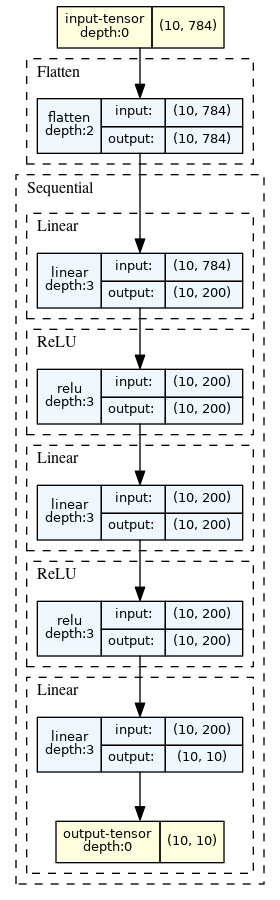

In [4]:
# setup our model now.

# Model 1: 2NN
class MNIST_2NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model_2NN = MNIST_2NN().to(system_args.device)
summary(model_2NN, input_size=(1,28*28), batch_size=system_args.local_bs)


model_graph = draw_graph(
  model_2NN, 
  input_size=(system_args.local_bs,28*28), 
  graph_name='my2NN',
  hide_inner_tensors=True,
  hide_module_functions=False,
  expand_nested=True,
  roll=True, # rolls recursive models
  save_graph=True
)
model_graph.visual_graph
#-----------------------------------------------------------------------

### Loading dataset


In [5]:
# grab MNIST data with torchvision datasets
## We can tell Pytorch how to manipulate the dataset by giving details.
##
### root: Where to store the data. We are storing it in data directory.
### train: Whether to grab training dataset or testing dataset. 
###         Given True value, training_data is a training dataset from MNIST. 
###         On the other hand, test_data is a testing dataset from MNIST.
### download: Whether to download if data is not already in root. We passed True to download the dataset.
### transform: What to do with data. We are converting our images of handwritten digits into Pytorch tensors so that we can train our model.

# Loading MNIST dataset using torchvision.datasets
training_data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_dataset = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

# Dividing the training data into num_clients, with each client having equal number of images
traindata_split = torch.utils.data.random_split(
    training_data, 
    [int(training_data.data.shape[0] / system_args.num_clients) for _ in range(system_args.num_clients)]
)
    
# Creating a pytorch loader for a Deep Learning model
train_loader = [torch.utils.data.DataLoader(x, batch_size=system_args.local_bs, shuffle=True) for x in traindata_split]

# Loading the test iamges and thus converting them into a test_loader
test_loader = torch.utils.data.DataLoader(
        test_dataset, 
        batch_size=system_args.local_bs, 
        shuffle=True
)


# check the dimension of data
print(training_data)
print('training data size: ', len(training_data) )
print('test data size: ', len(test_dataset) )
print(training_data[0][0].shape)
print(training_data[0][0].squeeze().shape)
# plt.imshow(training_data[len(training_data)-1][0].squeeze(), cmap="gray");
# print('label: ', training_data[len(training_data)-1][1])




Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
training data size:  60000
test data size:  10000
torch.Size([1, 28, 28])
torch.Size([28, 28])


### Training the model

In [6]:
############################################
#### Initializing models and optimizer  ####
############################################

#### global model ##########
# global_model =  VGG('VGG19').cuda()
global_model =  MNIST_2NN().to(system_args.device)

############## client models ##############
# client_models = [ VGG('VGG19').cuda() for _ in range(num_selected)]
client_models = [ MNIST_2NN().to(system_args.device) for _ in range(system_args.num_selected)]
for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
opt = [optim.SGD(model.parameters(), lr=system_args.lr) for model in client_models]

###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(system_args.num_rounds):
    # select random clients
    client_idx = np.random.permutation(system_args.num_clients)[:system_args.num_selected]
    # client update
    loss = 0
    for i in tqdm(range(system_args.num_selected)):
        loss += client_update(client_models[i], opt[i], train_loader[client_idx[i]], system_args)
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models, system_args)
    
    test_loss, acc = test(global_model, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / system_args.num_selected, test_loss, acc))

100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.51it/s]


0-th round
average train loss 2.29 | test loss 2.29 | test acc: 0.143


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.54it/s]


1-th round
average train loss 2.29 | test loss 2.28 | test acc: 0.192


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


2-th round
average train loss 2.29 | test loss 2.27 | test acc: 0.235


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


3-th round
average train loss 2.27 | test loss 2.26 | test acc: 0.303


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]


4-th round
average train loss 2.25 | test loss 2.25 | test acc: 0.392


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


5-th round
average train loss 2.24 | test loss 2.24 | test acc: 0.480


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.52it/s]


6-th round
average train loss 2.23 | test loss 2.22 | test acc: 0.558


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.54it/s]


7-th round
average train loss 2.21 | test loss 2.2 | test acc: 0.613


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.54it/s]


8-th round
average train loss 2.16 | test loss 2.17 | test acc: 0.640


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


9-th round
average train loss 2.16 | test loss 2.14 | test acc: 0.661


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


10-th round
average train loss 2.1 | test loss 2.1 | test acc: 0.669


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


11-th round
average train loss 2.1 | test loss 2.06 | test acc: 0.676


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.52it/s]


12-th round
average train loss 2.01 | test loss 2.01 | test acc: 0.681


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


13-th round
average train loss 1.95 | test loss 1.95 | test acc: 0.679


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


14-th round
average train loss 1.91 | test loss 1.88 | test acc: 0.666


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


15-th round
average train loss 1.81 | test loss 1.8 | test acc: 0.659


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


16-th round
average train loss 1.7 | test loss 1.72 | test acc: 0.679


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


17-th round
average train loss 1.59 | test loss 1.62 | test acc: 0.684


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


18-th round
average train loss 1.52 | test loss 1.53 | test acc: 0.705


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


19-th round
average train loss 1.39 | test loss 1.43 | test acc: 0.706


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


20-th round
average train loss 1.3 | test loss 1.34 | test acc: 0.721


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


21-th round
average train loss 1.29 | test loss 1.25 | test acc: 0.742


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


22-th round
average train loss 1.2 | test loss 1.17 | test acc: 0.751


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


23-th round
average train loss 1.17 | test loss 1.1 | test acc: 0.755


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


24-th round
average train loss 1.03 | test loss 1.04 | test acc: 0.754


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


25-th round
average train loss 0.972 | test loss 0.98 | test acc: 0.778


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


26-th round
average train loss 0.98 | test loss 0.93 | test acc: 0.782


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


27-th round
average train loss 0.829 | test loss 0.885 | test acc: 0.788


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


28-th round
average train loss 0.977 | test loss 0.845 | test acc: 0.799


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


29-th round
average train loss 0.876 | test loss 0.81 | test acc: 0.804


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


30-th round
average train loss 0.82 | test loss 0.777 | test acc: 0.808


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


31-th round
average train loss 0.823 | test loss 0.748 | test acc: 0.810


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


32-th round
average train loss 0.817 | test loss 0.723 | test acc: 0.817


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


33-th round
average train loss 0.692 | test loss 0.698 | test acc: 0.827


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


34-th round
average train loss 0.653 | test loss 0.676 | test acc: 0.828


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


35-th round
average train loss 0.557 | test loss 0.655 | test acc: 0.832


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


36-th round
average train loss 0.685 | test loss 0.636 | test acc: 0.838


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


37-th round
average train loss 0.628 | test loss 0.621 | test acc: 0.842


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


38-th round
average train loss 0.571 | test loss 0.603 | test acc: 0.845


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


39-th round
average train loss 0.504 | test loss 0.587 | test acc: 0.849


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


40-th round
average train loss 0.78 | test loss 0.575 | test acc: 0.848


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


41-th round
average train loss 0.614 | test loss 0.563 | test acc: 0.855


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


42-th round
average train loss 0.505 | test loss 0.55 | test acc: 0.854


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


43-th round
average train loss 0.543 | test loss 0.537 | test acc: 0.858


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


44-th round
average train loss 0.647 | test loss 0.528 | test acc: 0.859


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


45-th round
average train loss 0.536 | test loss 0.518 | test acc: 0.862


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


46-th round
average train loss 0.468 | test loss 0.509 | test acc: 0.865


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


47-th round
average train loss 0.522 | test loss 0.5 | test acc: 0.866


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


48-th round
average train loss 0.55 | test loss 0.491 | test acc: 0.868


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


49-th round
average train loss 0.572 | test loss 0.485 | test acc: 0.869


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


50-th round
average train loss 0.525 | test loss 0.478 | test acc: 0.872


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


51-th round
average train loss 0.429 | test loss 0.47 | test acc: 0.873


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


52-th round
average train loss 0.55 | test loss 0.463 | test acc: 0.875


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


53-th round
average train loss 0.418 | test loss 0.458 | test acc: 0.875


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


54-th round
average train loss 0.487 | test loss 0.451 | test acc: 0.876


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


55-th round
average train loss 0.431 | test loss 0.448 | test acc: 0.878


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


56-th round
average train loss 0.324 | test loss 0.44 | test acc: 0.881


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


57-th round
average train loss 0.43 | test loss 0.436 | test acc: 0.883


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


58-th round
average train loss 0.576 | test loss 0.432 | test acc: 0.883


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


59-th round
average train loss 0.4 | test loss 0.427 | test acc: 0.884


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


60-th round
average train loss 0.398 | test loss 0.422 | test acc: 0.885


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


61-th round
average train loss 0.381 | test loss 0.419 | test acc: 0.885


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


62-th round
average train loss 0.509 | test loss 0.417 | test acc: 0.885


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


63-th round
average train loss 0.404 | test loss 0.411 | test acc: 0.887


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


64-th round
average train loss 0.346 | test loss 0.407 | test acc: 0.888


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


65-th round
average train loss 0.423 | test loss 0.404 | test acc: 0.889


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


66-th round
average train loss 0.356 | test loss 0.401 | test acc: 0.888


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


67-th round
average train loss 0.526 | test loss 0.397 | test acc: 0.889


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


68-th round
average train loss 0.561 | test loss 0.396 | test acc: 0.889


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


69-th round
average train loss 0.426 | test loss 0.391 | test acc: 0.891


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


70-th round
average train loss 0.555 | test loss 0.388 | test acc: 0.891


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


71-th round
average train loss 0.291 | test loss 0.386 | test acc: 0.892


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


72-th round
average train loss 0.455 | test loss 0.382 | test acc: 0.893


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


73-th round
average train loss 0.34 | test loss 0.38 | test acc: 0.894


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


74-th round
average train loss 0.406 | test loss 0.378 | test acc: 0.893


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


75-th round
average train loss 0.334 | test loss 0.374 | test acc: 0.894


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


76-th round
average train loss 0.359 | test loss 0.373 | test acc: 0.896


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


77-th round
average train loss 0.242 | test loss 0.371 | test acc: 0.896


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


78-th round
average train loss 0.346 | test loss 0.368 | test acc: 0.896


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


79-th round
average train loss 0.458 | test loss 0.366 | test acc: 0.897


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


80-th round
average train loss 0.471 | test loss 0.365 | test acc: 0.896


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


81-th round
average train loss 0.446 | test loss 0.364 | test acc: 0.897


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


82-th round
average train loss 0.352 | test loss 0.361 | test acc: 0.898


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


83-th round
average train loss 0.525 | test loss 0.359 | test acc: 0.898


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


84-th round
average train loss 0.421 | test loss 0.357 | test acc: 0.898


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


85-th round
average train loss 0.414 | test loss 0.356 | test acc: 0.898


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


86-th round
average train loss 0.297 | test loss 0.355 | test acc: 0.899


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


87-th round
average train loss 0.414 | test loss 0.352 | test acc: 0.901


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


88-th round
average train loss 0.341 | test loss 0.351 | test acc: 0.899


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


89-th round
average train loss 0.34 | test loss 0.349 | test acc: 0.900


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


90-th round
average train loss 0.283 | test loss 0.347 | test acc: 0.901


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


91-th round
average train loss 0.356 | test loss 0.346 | test acc: 0.902


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


92-th round
average train loss 0.333 | test loss 0.344 | test acc: 0.901


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


93-th round
average train loss 0.425 | test loss 0.342 | test acc: 0.903


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


94-th round
average train loss 0.333 | test loss 0.341 | test acc: 0.903


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


95-th round
average train loss 0.374 | test loss 0.339 | test acc: 0.904


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


96-th round
average train loss 0.513 | test loss 0.34 | test acc: 0.902


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


97-th round
average train loss 0.372 | test loss 0.337 | test acc: 0.903


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


98-th round
average train loss 0.332 | test loss 0.336 | test acc: 0.904


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


99-th round
average train loss 0.376 | test loss 0.335 | test acc: 0.904


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


100-th round
average train loss 0.33 | test loss 0.334 | test acc: 0.903


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


101-th round
average train loss 0.357 | test loss 0.332 | test acc: 0.903


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


102-th round
average train loss 0.371 | test loss 0.33 | test acc: 0.905


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


103-th round
average train loss 0.31 | test loss 0.329 | test acc: 0.906


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


104-th round
average train loss 0.273 | test loss 0.328 | test acc: 0.906


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


105-th round
average train loss 0.42 | test loss 0.328 | test acc: 0.905


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


106-th round
average train loss 0.309 | test loss 0.326 | test acc: 0.906


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


107-th round
average train loss 0.314 | test loss 0.326 | test acc: 0.905


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.49it/s]


108-th round
average train loss 0.323 | test loss 0.324 | test acc: 0.905


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.53it/s]


109-th round
average train loss 0.535 | test loss 0.323 | test acc: 0.906


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


110-th round
average train loss 0.277 | test loss 0.321 | test acc: 0.907


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


111-th round
average train loss 0.308 | test loss 0.32 | test acc: 0.909


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


112-th round
average train loss 0.341 | test loss 0.32 | test acc: 0.908


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


113-th round
average train loss 0.435 | test loss 0.318 | test acc: 0.908


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


114-th round
average train loss 0.419 | test loss 0.317 | test acc: 0.908


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


115-th round
average train loss 0.315 | test loss 0.316 | test acc: 0.909


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


116-th round
average train loss 0.366 | test loss 0.316 | test acc: 0.909


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


117-th round
average train loss 0.309 | test loss 0.314 | test acc: 0.908


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


118-th round
average train loss 0.406 | test loss 0.313 | test acc: 0.909


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


119-th round
average train loss 0.306 | test loss 0.313 | test acc: 0.909


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


120-th round
average train loss 0.309 | test loss 0.312 | test acc: 0.910


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


121-th round
average train loss 0.498 | test loss 0.311 | test acc: 0.910


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


122-th round
average train loss 0.411 | test loss 0.31 | test acc: 0.910


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


123-th round
average train loss 0.398 | test loss 0.31 | test acc: 0.910


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


124-th round
average train loss 0.274 | test loss 0.308 | test acc: 0.911


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


125-th round
average train loss 0.29 | test loss 0.308 | test acc: 0.910


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


126-th round
average train loss 0.418 | test loss 0.307 | test acc: 0.911


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


127-th round
average train loss 0.262 | test loss 0.305 | test acc: 0.911


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


128-th round
average train loss 0.336 | test loss 0.305 | test acc: 0.912


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


129-th round
average train loss 0.326 | test loss 0.304 | test acc: 0.912


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


130-th round
average train loss 0.444 | test loss 0.303 | test acc: 0.911


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


131-th round
average train loss 0.465 | test loss 0.304 | test acc: 0.911


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


132-th round
average train loss 0.331 | test loss 0.301 | test acc: 0.911


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


133-th round
average train loss 0.301 | test loss 0.3 | test acc: 0.912


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


134-th round
average train loss 0.32 | test loss 0.3 | test acc: 0.913


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


135-th round
average train loss 0.263 | test loss 0.299 | test acc: 0.913


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


136-th round
average train loss 0.258 | test loss 0.298 | test acc: 0.912


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


137-th round
average train loss 0.43 | test loss 0.298 | test acc: 0.914


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


138-th round
average train loss 0.419 | test loss 0.297 | test acc: 0.913


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


139-th round
average train loss 0.388 | test loss 0.296 | test acc: 0.915


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


140-th round
average train loss 0.326 | test loss 0.296 | test acc: 0.914


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


141-th round
average train loss 0.403 | test loss 0.295 | test acc: 0.915


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


142-th round
average train loss 0.152 | test loss 0.295 | test acc: 0.915


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


143-th round
average train loss 0.222 | test loss 0.293 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


144-th round
average train loss 0.292 | test loss 0.292 | test acc: 0.915


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


145-th round
average train loss 0.359 | test loss 0.291 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


146-th round
average train loss 0.361 | test loss 0.292 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


147-th round
average train loss 0.306 | test loss 0.291 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


148-th round
average train loss 0.307 | test loss 0.29 | test acc: 0.917


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


149-th round
average train loss 0.258 | test loss 0.289 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


150-th round
average train loss 0.265 | test loss 0.288 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


151-th round
average train loss 0.325 | test loss 0.288 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


152-th round
average train loss 0.138 | test loss 0.287 | test acc: 0.917


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


153-th round
average train loss 0.145 | test loss 0.286 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


154-th round
average train loss 0.482 | test loss 0.286 | test acc: 0.916


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


155-th round
average train loss 0.227 | test loss 0.285 | test acc: 0.917


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


156-th round
average train loss 0.368 | test loss 0.284 | test acc: 0.918


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


157-th round
average train loss 0.313 | test loss 0.284 | test acc: 0.918


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


158-th round
average train loss 0.27 | test loss 0.284 | test acc: 0.918


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


159-th round
average train loss 0.203 | test loss 0.283 | test acc: 0.919


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


160-th round
average train loss 0.401 | test loss 0.283 | test acc: 0.919


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


161-th round
average train loss 0.407 | test loss 0.282 | test acc: 0.919


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


162-th round
average train loss 0.215 | test loss 0.281 | test acc: 0.919


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


163-th round
average train loss 0.196 | test loss 0.28 | test acc: 0.919


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


164-th round
average train loss 0.264 | test loss 0.279 | test acc: 0.920


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


165-th round
average train loss 0.261 | test loss 0.278 | test acc: 0.919


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


166-th round
average train loss 0.295 | test loss 0.278 | test acc: 0.919


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


167-th round
average train loss 0.203 | test loss 0.277 | test acc: 0.920


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


168-th round
average train loss 0.264 | test loss 0.276 | test acc: 0.920


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


169-th round
average train loss 0.422 | test loss 0.276 | test acc: 0.921


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


170-th round
average train loss 0.135 | test loss 0.276 | test acc: 0.920


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


171-th round
average train loss 0.346 | test loss 0.275 | test acc: 0.920


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


172-th round
average train loss 0.273 | test loss 0.275 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


173-th round
average train loss 0.398 | test loss 0.274 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


174-th round
average train loss 0.371 | test loss 0.274 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


175-th round
average train loss 0.336 | test loss 0.273 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


176-th round
average train loss 0.348 | test loss 0.274 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


177-th round
average train loss 0.288 | test loss 0.272 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


178-th round
average train loss 0.429 | test loss 0.272 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


179-th round
average train loss 0.0971 | test loss 0.271 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


180-th round
average train loss 0.422 | test loss 0.271 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


181-th round
average train loss 0.242 | test loss 0.27 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


182-th round
average train loss 0.274 | test loss 0.27 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


183-th round
average train loss 0.224 | test loss 0.268 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


184-th round
average train loss 0.193 | test loss 0.268 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


185-th round
average train loss 0.249 | test loss 0.268 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


186-th round
average train loss 0.155 | test loss 0.267 | test acc: 0.922


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


187-th round
average train loss 0.282 | test loss 0.267 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


188-th round
average train loss 0.175 | test loss 0.266 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


189-th round
average train loss 0.221 | test loss 0.266 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


190-th round
average train loss 0.186 | test loss 0.265 | test acc: 0.923


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


191-th round
average train loss 0.182 | test loss 0.265 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


192-th round
average train loss 0.23 | test loss 0.264 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


193-th round
average train loss 0.508 | test loss 0.264 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


194-th round
average train loss 0.393 | test loss 0.263 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


195-th round
average train loss 0.248 | test loss 0.264 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


196-th round
average train loss 0.221 | test loss 0.263 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


197-th round
average train loss 0.319 | test loss 0.262 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.53it/s]


198-th round
average train loss 0.158 | test loss 0.261 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


199-th round
average train loss 0.223 | test loss 0.26 | test acc: 0.925


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


200-th round
average train loss 0.29 | test loss 0.26 | test acc: 0.924


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


201-th round
average train loss 0.218 | test loss 0.26 | test acc: 0.925


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


202-th round
average train loss 0.158 | test loss 0.258 | test acc: 0.925


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


203-th round
average train loss 0.245 | test loss 0.258 | test acc: 0.926


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


204-th round
average train loss 0.379 | test loss 0.258 | test acc: 0.925


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


205-th round
average train loss 0.278 | test loss 0.257 | test acc: 0.925


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


206-th round
average train loss 0.478 | test loss 0.257 | test acc: 0.925


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


207-th round
average train loss 0.414 | test loss 0.256 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


208-th round
average train loss 0.22 | test loss 0.255 | test acc: 0.925


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


209-th round
average train loss 0.163 | test loss 0.255 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


210-th round
average train loss 0.341 | test loss 0.255 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


211-th round
average train loss 0.231 | test loss 0.254 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


212-th round
average train loss 0.144 | test loss 0.254 | test acc: 0.926


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


213-th round
average train loss 0.45 | test loss 0.253 | test acc: 0.926


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


214-th round
average train loss 0.317 | test loss 0.253 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


215-th round
average train loss 0.139 | test loss 0.253 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


216-th round
average train loss 0.377 | test loss 0.252 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


217-th round
average train loss 0.336 | test loss 0.252 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


218-th round
average train loss 0.199 | test loss 0.251 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.49it/s]


219-th round
average train loss 0.247 | test loss 0.252 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.48it/s]


220-th round
average train loss 0.191 | test loss 0.251 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


221-th round
average train loss 0.232 | test loss 0.249 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


222-th round
average train loss 0.324 | test loss 0.25 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


223-th round
average train loss 0.163 | test loss 0.249 | test acc: 0.927


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


224-th round
average train loss 0.276 | test loss 0.248 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


225-th round
average train loss 0.234 | test loss 0.248 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


226-th round
average train loss 0.381 | test loss 0.247 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


227-th round
average train loss 0.232 | test loss 0.248 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


228-th round
average train loss 0.187 | test loss 0.247 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


229-th round
average train loss 0.278 | test loss 0.247 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


230-th round
average train loss 0.326 | test loss 0.246 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


231-th round
average train loss 0.214 | test loss 0.245 | test acc: 0.928


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


232-th round
average train loss 0.186 | test loss 0.244 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


233-th round
average train loss 0.231 | test loss 0.244 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


234-th round
average train loss 0.34 | test loss 0.244 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


235-th round
average train loss 0.211 | test loss 0.244 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


236-th round
average train loss 0.262 | test loss 0.243 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


237-th round
average train loss 0.223 | test loss 0.243 | test acc: 0.929


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


238-th round
average train loss 0.218 | test loss 0.242 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


239-th round
average train loss 0.254 | test loss 0.241 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


240-th round
average train loss 0.368 | test loss 0.241 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


241-th round
average train loss 0.34 | test loss 0.24 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


242-th round
average train loss 0.378 | test loss 0.241 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


243-th round
average train loss 0.309 | test loss 0.241 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


244-th round
average train loss 0.287 | test loss 0.239 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.50it/s]


245-th round
average train loss 0.219 | test loss 0.238 | test acc: 0.930


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


246-th round
average train loss 0.397 | test loss 0.239 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


247-th round
average train loss 0.27 | test loss 0.238 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


248-th round
average train loss 0.249 | test loss 0.238 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


249-th round
average train loss 0.213 | test loss 0.238 | test acc: 0.932


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


250-th round
average train loss 0.158 | test loss 0.237 | test acc: 0.932


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


251-th round
average train loss 0.173 | test loss 0.237 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


252-th round
average train loss 0.252 | test loss 0.236 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


253-th round
average train loss 0.306 | test loss 0.236 | test acc: 0.932


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


254-th round
average train loss 0.119 | test loss 0.235 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


255-th round
average train loss 0.382 | test loss 0.234 | test acc: 0.932


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.50it/s]


256-th round
average train loss 0.272 | test loss 0.234 | test acc: 0.932


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


257-th round
average train loss 0.212 | test loss 0.234 | test acc: 0.933


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


258-th round
average train loss 0.268 | test loss 0.233 | test acc: 0.933


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


259-th round
average train loss 0.215 | test loss 0.233 | test acc: 0.933


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


260-th round
average train loss 0.207 | test loss 0.233 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


261-th round
average train loss 0.26 | test loss 0.233 | test acc: 0.931


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


262-th round
average train loss 0.393 | test loss 0.232 | test acc: 0.933


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


263-th round
average train loss 0.369 | test loss 0.231 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


264-th round
average train loss 0.182 | test loss 0.23 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


265-th round
average train loss 0.185 | test loss 0.231 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


266-th round
average train loss 0.165 | test loss 0.23 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


267-th round
average train loss 0.166 | test loss 0.23 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


268-th round
average train loss 0.226 | test loss 0.229 | test acc: 0.933


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


269-th round
average train loss 0.18 | test loss 0.229 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


270-th round
average train loss 0.146 | test loss 0.228 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


271-th round
average train loss 0.219 | test loss 0.227 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


272-th round
average train loss 0.295 | test loss 0.227 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


273-th round
average train loss 0.308 | test loss 0.227 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


274-th round
average train loss 0.113 | test loss 0.226 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


275-th round
average train loss 0.217 | test loss 0.225 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


276-th round
average train loss 0.469 | test loss 0.225 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


277-th round
average train loss 0.237 | test loss 0.225 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


278-th round
average train loss 0.215 | test loss 0.226 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


279-th round
average train loss 0.176 | test loss 0.224 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


280-th round
average train loss 0.236 | test loss 0.224 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


281-th round
average train loss 0.276 | test loss 0.223 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


282-th round
average train loss 0.219 | test loss 0.223 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


283-th round
average train loss 0.168 | test loss 0.223 | test acc: 0.934


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


284-th round
average train loss 0.248 | test loss 0.223 | test acc: 0.935


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


285-th round
average train loss 0.192 | test loss 0.222 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


286-th round
average train loss 0.395 | test loss 0.221 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


287-th round
average train loss 0.201 | test loss 0.221 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


288-th round
average train loss 0.27 | test loss 0.22 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


289-th round
average train loss 0.245 | test loss 0.22 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


290-th round
average train loss 0.189 | test loss 0.22 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


291-th round
average train loss 0.197 | test loss 0.219 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


292-th round
average train loss 0.198 | test loss 0.219 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


293-th round
average train loss 0.207 | test loss 0.219 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


294-th round
average train loss 0.288 | test loss 0.218 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


295-th round
average train loss 0.226 | test loss 0.218 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


296-th round
average train loss 0.324 | test loss 0.218 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


297-th round
average train loss 0.396 | test loss 0.217 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


298-th round
average train loss 0.245 | test loss 0.216 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


299-th round
average train loss 0.286 | test loss 0.216 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


300-th round
average train loss 0.137 | test loss 0.215 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


301-th round
average train loss 0.2 | test loss 0.215 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


302-th round
average train loss 0.267 | test loss 0.215 | test acc: 0.937


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


303-th round
average train loss 0.359 | test loss 0.214 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


304-th round
average train loss 0.214 | test loss 0.214 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


305-th round
average train loss 0.316 | test loss 0.215 | test acc: 0.939


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


306-th round
average train loss 0.376 | test loss 0.213 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


307-th round
average train loss 0.173 | test loss 0.213 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


308-th round
average train loss 0.142 | test loss 0.213 | test acc: 0.936


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


309-th round
average train loss 0.191 | test loss 0.213 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


310-th round
average train loss 0.126 | test loss 0.212 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


311-th round
average train loss 0.162 | test loss 0.212 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


312-th round
average train loss 0.161 | test loss 0.211 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


313-th round
average train loss 0.248 | test loss 0.211 | test acc: 0.939


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


314-th round
average train loss 0.254 | test loss 0.21 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


315-th round
average train loss 0.218 | test loss 0.21 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


316-th round
average train loss 0.281 | test loss 0.21 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


317-th round
average train loss 0.182 | test loss 0.21 | test acc: 0.939


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


318-th round
average train loss 0.144 | test loss 0.21 | test acc: 0.939


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


319-th round
average train loss 0.167 | test loss 0.209 | test acc: 0.939


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


320-th round
average train loss 0.182 | test loss 0.208 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


321-th round
average train loss 0.254 | test loss 0.208 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


322-th round
average train loss 0.121 | test loss 0.208 | test acc: 0.938


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


323-th round
average train loss 0.218 | test loss 0.206 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


324-th round
average train loss 0.218 | test loss 0.206 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


325-th round
average train loss 0.255 | test loss 0.206 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


326-th round
average train loss 0.187 | test loss 0.206 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


327-th round
average train loss 0.186 | test loss 0.205 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


328-th round
average train loss 0.183 | test loss 0.206 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


329-th round
average train loss 0.156 | test loss 0.205 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


330-th round
average train loss 0.247 | test loss 0.206 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


331-th round
average train loss 0.214 | test loss 0.205 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


332-th round
average train loss 0.22 | test loss 0.204 | test acc: 0.940


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


333-th round
average train loss 0.312 | test loss 0.204 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


334-th round
average train loss 0.197 | test loss 0.204 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


335-th round
average train loss 0.278 | test loss 0.204 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


336-th round
average train loss 0.202 | test loss 0.203 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


337-th round
average train loss 0.183 | test loss 0.202 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


338-th round
average train loss 0.314 | test loss 0.202 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


339-th round
average train loss 0.208 | test loss 0.202 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


340-th round
average train loss 0.219 | test loss 0.203 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


341-th round
average train loss 0.164 | test loss 0.201 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


342-th round
average train loss 0.269 | test loss 0.2 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


343-th round
average train loss 0.312 | test loss 0.2 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


344-th round
average train loss 0.207 | test loss 0.201 | test acc: 0.941


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


345-th round
average train loss 0.231 | test loss 0.199 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


346-th round
average train loss 0.136 | test loss 0.2 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


347-th round
average train loss 0.129 | test loss 0.198 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


348-th round
average train loss 0.0599 | test loss 0.198 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


349-th round
average train loss 0.153 | test loss 0.198 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


350-th round
average train loss 0.174 | test loss 0.197 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


351-th round
average train loss 0.212 | test loss 0.197 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


352-th round
average train loss 0.201 | test loss 0.197 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


353-th round
average train loss 0.198 | test loss 0.197 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


354-th round
average train loss 0.222 | test loss 0.196 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


355-th round
average train loss 0.292 | test loss 0.195 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


356-th round
average train loss 0.181 | test loss 0.195 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


357-th round
average train loss 0.364 | test loss 0.195 | test acc: 0.942


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


358-th round
average train loss 0.161 | test loss 0.196 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


359-th round
average train loss 0.151 | test loss 0.195 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


360-th round
average train loss 0.121 | test loss 0.195 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


361-th round
average train loss 0.247 | test loss 0.195 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


362-th round
average train loss 0.107 | test loss 0.194 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


363-th round
average train loss 0.301 | test loss 0.194 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


364-th round
average train loss 0.193 | test loss 0.193 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


365-th round
average train loss 0.283 | test loss 0.193 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


366-th round
average train loss 0.16 | test loss 0.193 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


367-th round
average train loss 0.218 | test loss 0.193 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


368-th round
average train loss 0.15 | test loss 0.191 | test acc: 0.943


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


369-th round
average train loss 0.159 | test loss 0.19 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


370-th round
average train loss 0.135 | test loss 0.191 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


371-th round
average train loss 0.287 | test loss 0.19 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


372-th round
average train loss 0.151 | test loss 0.19 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


373-th round
average train loss 0.313 | test loss 0.19 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


374-th round
average train loss 0.147 | test loss 0.191 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


375-th round
average train loss 0.234 | test loss 0.19 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


376-th round
average train loss 0.281 | test loss 0.189 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


377-th round
average train loss 0.155 | test loss 0.189 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


378-th round
average train loss 0.171 | test loss 0.189 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


379-th round
average train loss 0.369 | test loss 0.189 | test acc: 0.944


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


380-th round
average train loss 0.284 | test loss 0.188 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


381-th round
average train loss 0.179 | test loss 0.188 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


382-th round
average train loss 0.237 | test loss 0.188 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


383-th round
average train loss 0.159 | test loss 0.188 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


384-th round
average train loss 0.272 | test loss 0.188 | test acc: 0.946


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


385-th round
average train loss 0.207 | test loss 0.188 | test acc: 0.946


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


386-th round
average train loss 0.128 | test loss 0.187 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


387-th round
average train loss 0.271 | test loss 0.187 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


388-th round
average train loss 0.37 | test loss 0.187 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


389-th round
average train loss 0.283 | test loss 0.185 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


390-th round
average train loss 0.138 | test loss 0.185 | test acc: 0.946


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


391-th round
average train loss 0.215 | test loss 0.184 | test acc: 0.946


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


392-th round
average train loss 0.225 | test loss 0.185 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


393-th round
average train loss 0.223 | test loss 0.184 | test acc: 0.946


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


394-th round
average train loss 0.159 | test loss 0.184 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


395-th round
average train loss 0.171 | test loss 0.183 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


396-th round
average train loss 0.157 | test loss 0.183 | test acc: 0.948


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


397-th round
average train loss 0.181 | test loss 0.183 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


398-th round
average train loss 0.237 | test loss 0.183 | test acc: 0.945


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


399-th round
average train loss 0.275 | test loss 0.183 | test acc: 0.948


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


400-th round
average train loss 0.214 | test loss 0.182 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


401-th round
average train loss 0.294 | test loss 0.182 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


402-th round
average train loss 0.237 | test loss 0.182 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


403-th round
average train loss 0.232 | test loss 0.181 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


404-th round
average train loss 0.218 | test loss 0.182 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


405-th round
average train loss 0.241 | test loss 0.181 | test acc: 0.947


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


406-th round
average train loss 0.131 | test loss 0.181 | test acc: 0.946


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


407-th round
average train loss 0.288 | test loss 0.18 | test acc: 0.948


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


408-th round
average train loss 0.215 | test loss 0.18 | test acc: 0.948


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


409-th round
average train loss 0.153 | test loss 0.179 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


410-th round
average train loss 0.141 | test loss 0.179 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


411-th round
average train loss 0.152 | test loss 0.179 | test acc: 0.948


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


412-th round
average train loss 0.188 | test loss 0.178 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


413-th round
average train loss 0.17 | test loss 0.178 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


414-th round
average train loss 0.259 | test loss 0.178 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


415-th round
average train loss 0.0956 | test loss 0.178 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


416-th round
average train loss 0.246 | test loss 0.177 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


417-th round
average train loss 0.115 | test loss 0.177 | test acc: 0.948


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


418-th round
average train loss 0.115 | test loss 0.177 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


419-th round
average train loss 0.251 | test loss 0.177 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


420-th round
average train loss 0.133 | test loss 0.176 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


421-th round
average train loss 0.118 | test loss 0.177 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


422-th round
average train loss 0.22 | test loss 0.176 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


423-th round
average train loss 0.193 | test loss 0.176 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


424-th round
average train loss 0.186 | test loss 0.175 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


425-th round
average train loss 0.1 | test loss 0.175 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


426-th round
average train loss 0.127 | test loss 0.175 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


427-th round
average train loss 0.25 | test loss 0.175 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


428-th round
average train loss 0.175 | test loss 0.174 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


429-th round
average train loss 0.239 | test loss 0.174 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


430-th round
average train loss 0.138 | test loss 0.174 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


431-th round
average train loss 0.131 | test loss 0.174 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


432-th round
average train loss 0.133 | test loss 0.173 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


433-th round
average train loss 0.222 | test loss 0.173 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


434-th round
average train loss 0.174 | test loss 0.172 | test acc: 0.949


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


435-th round
average train loss 0.19 | test loss 0.173 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


436-th round
average train loss 0.148 | test loss 0.172 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


437-th round
average train loss 0.185 | test loss 0.172 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


438-th round
average train loss 0.15 | test loss 0.172 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


439-th round
average train loss 0.153 | test loss 0.172 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


440-th round
average train loss 0.0989 | test loss 0.171 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


441-th round
average train loss 0.145 | test loss 0.17 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


442-th round
average train loss 0.146 | test loss 0.17 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


443-th round
average train loss 0.18 | test loss 0.171 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


444-th round
average train loss 0.141 | test loss 0.17 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


445-th round
average train loss 0.203 | test loss 0.169 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


446-th round
average train loss 0.135 | test loss 0.17 | test acc: 0.950


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


447-th round
average train loss 0.145 | test loss 0.169 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


448-th round
average train loss 0.18 | test loss 0.17 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


449-th round
average train loss 0.167 | test loss 0.169 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


450-th round
average train loss 0.285 | test loss 0.169 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


451-th round
average train loss 0.0893 | test loss 0.169 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


452-th round
average train loss 0.202 | test loss 0.168 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


453-th round
average train loss 0.356 | test loss 0.168 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


454-th round
average train loss 0.241 | test loss 0.169 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


455-th round
average train loss 0.136 | test loss 0.168 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


456-th round
average train loss 0.156 | test loss 0.168 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


457-th round
average train loss 0.227 | test loss 0.168 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


458-th round
average train loss 0.238 | test loss 0.167 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


459-th round
average train loss 0.101 | test loss 0.166 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


460-th round
average train loss 0.241 | test loss 0.167 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


461-th round
average train loss 0.101 | test loss 0.166 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


462-th round
average train loss 0.104 | test loss 0.166 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


463-th round
average train loss 0.118 | test loss 0.166 | test acc: 0.951


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


464-th round
average train loss 0.103 | test loss 0.166 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


465-th round
average train loss 0.221 | test loss 0.166 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


466-th round
average train loss 0.213 | test loss 0.165 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


467-th round
average train loss 0.157 | test loss 0.165 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


468-th round
average train loss 0.279 | test loss 0.166 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


469-th round
average train loss 0.299 | test loss 0.166 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


470-th round
average train loss 0.102 | test loss 0.165 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


471-th round
average train loss 0.172 | test loss 0.165 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


472-th round
average train loss 0.133 | test loss 0.164 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


473-th round
average train loss 0.297 | test loss 0.163 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


474-th round
average train loss 0.164 | test loss 0.164 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


475-th round
average train loss 0.0834 | test loss 0.164 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


476-th round
average train loss 0.259 | test loss 0.163 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


477-th round
average train loss 0.116 | test loss 0.163 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


478-th round
average train loss 0.168 | test loss 0.162 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


479-th round
average train loss 0.159 | test loss 0.163 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


480-th round
average train loss 0.228 | test loss 0.162 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


481-th round
average train loss 0.126 | test loss 0.163 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


482-th round
average train loss 0.0767 | test loss 0.163 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


483-th round
average train loss 0.145 | test loss 0.162 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


484-th round
average train loss 0.234 | test loss 0.161 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


485-th round
average train loss 0.128 | test loss 0.161 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


486-th round
average train loss 0.217 | test loss 0.16 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


487-th round
average train loss 0.0475 | test loss 0.161 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


488-th round
average train loss 0.289 | test loss 0.161 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


489-th round
average train loss 0.172 | test loss 0.161 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


490-th round
average train loss 0.186 | test loss 0.161 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


491-th round
average train loss 0.151 | test loss 0.16 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


492-th round
average train loss 0.3 | test loss 0.16 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


493-th round
average train loss 0.0922 | test loss 0.16 | test acc: 0.952


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


494-th round
average train loss 0.198 | test loss 0.159 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


495-th round
average train loss 0.201 | test loss 0.158 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


496-th round
average train loss 0.251 | test loss 0.159 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


497-th round
average train loss 0.187 | test loss 0.158 | test acc: 0.953


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


498-th round
average train loss 0.221 | test loss 0.158 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


499-th round
average train loss 0.0853 | test loss 0.158 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


500-th round
average train loss 0.193 | test loss 0.158 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


501-th round
average train loss 0.0894 | test loss 0.158 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


502-th round
average train loss 0.16 | test loss 0.158 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


503-th round
average train loss 0.0852 | test loss 0.158 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


504-th round
average train loss 0.124 | test loss 0.156 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


505-th round
average train loss 0.0952 | test loss 0.157 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


506-th round
average train loss 0.0988 | test loss 0.156 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


507-th round
average train loss 0.151 | test loss 0.157 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


508-th round
average train loss 0.101 | test loss 0.157 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


509-th round
average train loss 0.161 | test loss 0.156 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


510-th round
average train loss 0.157 | test loss 0.156 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


511-th round
average train loss 0.136 | test loss 0.156 | test acc: 0.954


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


512-th round
average train loss 0.317 | test loss 0.155 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


513-th round
average train loss 0.118 | test loss 0.155 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


514-th round
average train loss 0.207 | test loss 0.154 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


515-th round
average train loss 0.141 | test loss 0.155 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


516-th round
average train loss 0.138 | test loss 0.154 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


517-th round
average train loss 0.195 | test loss 0.154 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


518-th round
average train loss 0.11 | test loss 0.154 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


519-th round
average train loss 0.078 | test loss 0.153 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


520-th round
average train loss 0.11 | test loss 0.153 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


521-th round
average train loss 0.131 | test loss 0.153 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


522-th round
average train loss 0.115 | test loss 0.153 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


523-th round
average train loss 0.103 | test loss 0.153 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


524-th round
average train loss 0.172 | test loss 0.152 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


525-th round
average train loss 0.173 | test loss 0.153 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


526-th round
average train loss 0.206 | test loss 0.151 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


527-th round
average train loss 0.131 | test loss 0.152 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


528-th round
average train loss 0.223 | test loss 0.152 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


529-th round
average train loss 0.0595 | test loss 0.151 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


530-th round
average train loss 0.219 | test loss 0.152 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


531-th round
average train loss 0.189 | test loss 0.151 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


532-th round
average train loss 0.155 | test loss 0.151 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


533-th round
average train loss 0.178 | test loss 0.151 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


534-th round
average train loss 0.0752 | test loss 0.151 | test acc: 0.955


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


535-th round
average train loss 0.232 | test loss 0.15 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


536-th round
average train loss 0.154 | test loss 0.15 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


537-th round
average train loss 0.0969 | test loss 0.15 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


538-th round
average train loss 0.154 | test loss 0.15 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


539-th round
average train loss 0.222 | test loss 0.15 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


540-th round
average train loss 0.152 | test loss 0.15 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


541-th round
average train loss 0.146 | test loss 0.149 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


542-th round
average train loss 0.269 | test loss 0.149 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


543-th round
average train loss 0.0465 | test loss 0.149 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


544-th round
average train loss 0.183 | test loss 0.149 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


545-th round
average train loss 0.0452 | test loss 0.149 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


546-th round
average train loss 0.113 | test loss 0.15 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


547-th round
average train loss 0.164 | test loss 0.149 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


548-th round
average train loss 0.119 | test loss 0.149 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


549-th round
average train loss 0.11 | test loss 0.147 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


550-th round
average train loss 0.132 | test loss 0.147 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


551-th round
average train loss 0.122 | test loss 0.148 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


552-th round
average train loss 0.116 | test loss 0.147 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


553-th round
average train loss 0.166 | test loss 0.147 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


554-th round
average train loss 0.111 | test loss 0.147 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


555-th round
average train loss 0.0701 | test loss 0.147 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


556-th round
average train loss 0.134 | test loss 0.147 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


557-th round
average train loss 0.196 | test loss 0.146 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


558-th round
average train loss 0.136 | test loss 0.146 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


559-th round
average train loss 0.0565 | test loss 0.146 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


560-th round
average train loss 0.191 | test loss 0.146 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


561-th round
average train loss 0.159 | test loss 0.146 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


562-th round
average train loss 0.195 | test loss 0.147 | test acc: 0.956


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


563-th round
average train loss 0.154 | test loss 0.146 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


564-th round
average train loss 0.074 | test loss 0.145 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


565-th round
average train loss 0.0794 | test loss 0.145 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


566-th round
average train loss 0.0867 | test loss 0.145 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


567-th round
average train loss 0.09 | test loss 0.144 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


568-th round
average train loss 0.258 | test loss 0.144 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


569-th round
average train loss 0.0648 | test loss 0.144 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


570-th round
average train loss 0.222 | test loss 0.144 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


571-th round
average train loss 0.0294 | test loss 0.144 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


572-th round
average train loss 0.114 | test loss 0.143 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


573-th round
average train loss 0.163 | test loss 0.143 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


574-th round
average train loss 0.115 | test loss 0.143 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


575-th round
average train loss 0.183 | test loss 0.144 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


576-th round
average train loss 0.138 | test loss 0.144 | test acc: 0.957


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


577-th round
average train loss 0.0963 | test loss 0.143 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


578-th round
average train loss 0.13 | test loss 0.143 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


579-th round
average train loss 0.201 | test loss 0.143 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


580-th round
average train loss 0.103 | test loss 0.142 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


581-th round
average train loss 0.136 | test loss 0.142 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


582-th round
average train loss 0.169 | test loss 0.142 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


583-th round
average train loss 0.0927 | test loss 0.141 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


584-th round
average train loss 0.174 | test loss 0.143 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


585-th round
average train loss 0.0993 | test loss 0.141 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


586-th round
average train loss 0.103 | test loss 0.141 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


587-th round
average train loss 0.191 | test loss 0.141 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


588-th round
average train loss 0.0776 | test loss 0.141 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


589-th round
average train loss 0.135 | test loss 0.141 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


590-th round
average train loss 0.177 | test loss 0.141 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


591-th round
average train loss 0.244 | test loss 0.141 | test acc: 0.958


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


592-th round
average train loss 0.085 | test loss 0.14 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


593-th round
average train loss 0.199 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


594-th round
average train loss 0.0937 | test loss 0.14 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


595-th round
average train loss 0.106 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


596-th round
average train loss 0.107 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


597-th round
average train loss 0.0985 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


598-th round
average train loss 0.124 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


599-th round
average train loss 0.13 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


600-th round
average train loss 0.209 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


601-th round
average train loss 0.129 | test loss 0.139 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


602-th round
average train loss 0.11 | test loss 0.138 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


603-th round
average train loss 0.0844 | test loss 0.138 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


604-th round
average train loss 0.159 | test loss 0.138 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


605-th round
average train loss 0.142 | test loss 0.138 | test acc: 0.959


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


606-th round
average train loss 0.153 | test loss 0.138 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


607-th round
average train loss 0.0677 | test loss 0.138 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


608-th round
average train loss 0.106 | test loss 0.138 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


609-th round
average train loss 0.222 | test loss 0.138 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


610-th round
average train loss 0.17 | test loss 0.137 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


611-th round
average train loss 0.144 | test loss 0.137 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


612-th round
average train loss 0.0781 | test loss 0.137 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


613-th round
average train loss 0.136 | test loss 0.137 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


614-th round
average train loss 0.0951 | test loss 0.136 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


615-th round
average train loss 0.108 | test loss 0.136 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


616-th round
average train loss 0.204 | test loss 0.136 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


617-th round
average train loss 0.125 | test loss 0.136 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


618-th round
average train loss 0.121 | test loss 0.135 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


619-th round
average train loss 0.128 | test loss 0.136 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


620-th round
average train loss 0.0681 | test loss 0.136 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


621-th round
average train loss 0.0576 | test loss 0.135 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


622-th round
average train loss 0.126 | test loss 0.135 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


623-th round
average train loss 0.109 | test loss 0.135 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


624-th round
average train loss 0.0954 | test loss 0.134 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


625-th round
average train loss 0.113 | test loss 0.135 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


626-th round
average train loss 0.0931 | test loss 0.134 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


627-th round
average train loss 0.137 | test loss 0.134 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


628-th round
average train loss 0.101 | test loss 0.135 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


629-th round
average train loss 0.131 | test loss 0.134 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


630-th round
average train loss 0.0998 | test loss 0.134 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


631-th round
average train loss 0.23 | test loss 0.133 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


632-th round
average train loss 0.209 | test loss 0.133 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


633-th round
average train loss 0.122 | test loss 0.133 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


634-th round
average train loss 0.103 | test loss 0.134 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


635-th round
average train loss 0.127 | test loss 0.134 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


636-th round
average train loss 0.29 | test loss 0.134 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


637-th round
average train loss 0.0721 | test loss 0.134 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


638-th round
average train loss 0.0588 | test loss 0.134 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


639-th round
average train loss 0.159 | test loss 0.133 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


640-th round
average train loss 0.337 | test loss 0.132 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


641-th round
average train loss 0.119 | test loss 0.133 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


642-th round
average train loss 0.142 | test loss 0.133 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


643-th round
average train loss 0.127 | test loss 0.132 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


644-th round
average train loss 0.0933 | test loss 0.132 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


645-th round
average train loss 0.197 | test loss 0.132 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


646-th round
average train loss 0.127 | test loss 0.132 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


647-th round
average train loss 0.141 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


648-th round
average train loss 0.115 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


649-th round
average train loss 0.036 | test loss 0.131 | test acc: 0.960


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


650-th round
average train loss 0.188 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


651-th round
average train loss 0.108 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


652-th round
average train loss 0.099 | test loss 0.131 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


653-th round
average train loss 0.148 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


654-th round
average train loss 0.217 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


655-th round
average train loss 0.0474 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


656-th round
average train loss 0.126 | test loss 0.131 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


657-th round
average train loss 0.0656 | test loss 0.13 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


658-th round
average train loss 0.0673 | test loss 0.13 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


659-th round
average train loss 0.198 | test loss 0.131 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


660-th round
average train loss 0.0473 | test loss 0.13 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


661-th round
average train loss 0.128 | test loss 0.13 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


662-th round
average train loss 0.185 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


663-th round
average train loss 0.0915 | test loss 0.129 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


664-th round
average train loss 0.133 | test loss 0.129 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


665-th round
average train loss 0.101 | test loss 0.13 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


666-th round
average train loss 0.165 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


667-th round
average train loss 0.114 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


668-th round
average train loss 0.0944 | test loss 0.13 | test acc: 0.961


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


669-th round
average train loss 0.134 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


670-th round
average train loss 0.11 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


671-th round
average train loss 0.14 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


672-th round
average train loss 0.0741 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


673-th round
average train loss 0.192 | test loss 0.129 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


674-th round
average train loss 0.325 | test loss 0.128 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


675-th round
average train loss 0.0961 | test loss 0.127 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


676-th round
average train loss 0.112 | test loss 0.127 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


677-th round
average train loss 0.0419 | test loss 0.128 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


678-th round
average train loss 0.0981 | test loss 0.127 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


679-th round
average train loss 0.17 | test loss 0.128 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


680-th round
average train loss 0.0551 | test loss 0.127 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


681-th round
average train loss 0.174 | test loss 0.128 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


682-th round
average train loss 0.176 | test loss 0.128 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


683-th round
average train loss 0.0608 | test loss 0.127 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


684-th round
average train loss 0.108 | test loss 0.127 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


685-th round
average train loss 0.0455 | test loss 0.127 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


686-th round
average train loss 0.147 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


687-th round
average train loss 0.0798 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


688-th round
average train loss 0.183 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


689-th round
average train loss 0.0827 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


690-th round
average train loss 0.168 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


691-th round
average train loss 0.149 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


692-th round
average train loss 0.112 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


693-th round
average train loss 0.117 | test loss 0.126 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


694-th round
average train loss 0.0882 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


695-th round
average train loss 0.237 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


696-th round
average train loss 0.101 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


697-th round
average train loss 0.122 | test loss 0.127 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


698-th round
average train loss 0.0922 | test loss 0.126 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


699-th round
average train loss 0.101 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


700-th round
average train loss 0.0729 | test loss 0.124 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


701-th round
average train loss 0.163 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


702-th round
average train loss 0.107 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


703-th round
average train loss 0.0736 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


704-th round
average train loss 0.0613 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


705-th round
average train loss 0.0586 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


706-th round
average train loss 0.108 | test loss 0.124 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


707-th round
average train loss 0.114 | test loss 0.125 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


708-th round
average train loss 0.0797 | test loss 0.124 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


709-th round
average train loss 0.213 | test loss 0.124 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


710-th round
average train loss 0.133 | test loss 0.124 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


711-th round
average train loss 0.111 | test loss 0.123 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


712-th round
average train loss 0.13 | test loss 0.124 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


713-th round
average train loss 0.131 | test loss 0.123 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


714-th round
average train loss 0.0569 | test loss 0.124 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


715-th round
average train loss 0.0694 | test loss 0.123 | test acc: 0.962


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


716-th round
average train loss 0.0462 | test loss 0.123 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


717-th round
average train loss 0.118 | test loss 0.124 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


718-th round
average train loss 0.12 | test loss 0.123 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


719-th round
average train loss 0.0496 | test loss 0.122 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


720-th round
average train loss 0.0627 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


721-th round
average train loss 0.18 | test loss 0.122 | test acc: 0.963


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


722-th round
average train loss 0.0778 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


723-th round
average train loss 0.119 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


724-th round
average train loss 0.124 | test loss 0.123 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


725-th round
average train loss 0.167 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


726-th round
average train loss 0.137 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


727-th round
average train loss 0.101 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


728-th round
average train loss 0.139 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


729-th round
average train loss 0.107 | test loss 0.121 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


730-th round
average train loss 0.128 | test loss 0.122 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


731-th round
average train loss 0.199 | test loss 0.121 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


732-th round
average train loss 0.0691 | test loss 0.121 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


733-th round
average train loss 0.0537 | test loss 0.121 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


734-th round
average train loss 0.105 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


735-th round
average train loss 0.123 | test loss 0.121 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


736-th round
average train loss 0.0655 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


737-th round
average train loss 0.186 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


738-th round
average train loss 0.0487 | test loss 0.121 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


739-th round
average train loss 0.192 | test loss 0.12 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


740-th round
average train loss 0.0461 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


741-th round
average train loss 0.0581 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


742-th round
average train loss 0.162 | test loss 0.12 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


743-th round
average train loss 0.124 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


744-th round
average train loss 0.139 | test loss 0.119 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


745-th round
average train loss 0.112 | test loss 0.119 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


746-th round
average train loss 0.117 | test loss 0.119 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


747-th round
average train loss 0.0636 | test loss 0.119 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


748-th round
average train loss 0.112 | test loss 0.119 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


749-th round
average train loss 0.0918 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


750-th round
average train loss 0.132 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


751-th round
average train loss 0.0581 | test loss 0.119 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


752-th round
average train loss 0.0704 | test loss 0.119 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


753-th round
average train loss 0.163 | test loss 0.12 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


754-th round
average train loss 0.109 | test loss 0.119 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


755-th round
average train loss 0.0766 | test loss 0.12 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


756-th round
average train loss 0.0458 | test loss 0.118 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.32it/s]


757-th round
average train loss 0.143 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


758-th round
average train loss 0.129 | test loss 0.118 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


759-th round
average train loss 0.0895 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


760-th round
average train loss 0.0757 | test loss 0.119 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


761-th round
average train loss 0.123 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


762-th round
average train loss 0.11 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


763-th round
average train loss 0.223 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


764-th round
average train loss 0.127 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


765-th round
average train loss 0.0369 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


766-th round
average train loss 0.151 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


767-th round
average train loss 0.141 | test loss 0.118 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


768-th round
average train loss 0.127 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


769-th round
average train loss 0.115 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


770-th round
average train loss 0.082 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


771-th round
average train loss 0.123 | test loss 0.116 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


772-th round
average train loss 0.159 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


773-th round
average train loss 0.0884 | test loss 0.117 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


774-th round
average train loss 0.0577 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


775-th round
average train loss 0.113 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


776-th round
average train loss 0.0639 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


777-th round
average train loss 0.198 | test loss 0.117 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


778-th round
average train loss 0.156 | test loss 0.116 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


779-th round
average train loss 0.112 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


780-th round
average train loss 0.119 | test loss 0.116 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


781-th round
average train loss 0.0292 | test loss 0.116 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


782-th round
average train loss 0.0688 | test loss 0.116 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


783-th round
average train loss 0.0619 | test loss 0.116 | test acc: 0.964


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


784-th round
average train loss 0.0961 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


785-th round
average train loss 0.0508 | test loss 0.115 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


786-th round
average train loss 0.156 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


787-th round
average train loss 0.111 | test loss 0.115 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


788-th round
average train loss 0.136 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


789-th round
average train loss 0.208 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


790-th round
average train loss 0.102 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


791-th round
average train loss 0.0453 | test loss 0.115 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


792-th round
average train loss 0.173 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


793-th round
average train loss 0.0949 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


794-th round
average train loss 0.0963 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


795-th round
average train loss 0.059 | test loss 0.115 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


796-th round
average train loss 0.102 | test loss 0.114 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


797-th round
average train loss 0.0969 | test loss 0.114 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


798-th round
average train loss 0.0728 | test loss 0.114 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


799-th round
average train loss 0.152 | test loss 0.115 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


800-th round
average train loss 0.065 | test loss 0.114 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


801-th round
average train loss 0.106 | test loss 0.114 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


802-th round
average train loss 0.0742 | test loss 0.114 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


803-th round
average train loss 0.1 | test loss 0.114 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


804-th round
average train loss 0.0756 | test loss 0.113 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


805-th round
average train loss 0.0942 | test loss 0.114 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


806-th round
average train loss 0.148 | test loss 0.114 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


807-th round
average train loss 0.0753 | test loss 0.114 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


808-th round
average train loss 0.074 | test loss 0.113 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


809-th round
average train loss 0.0287 | test loss 0.113 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


810-th round
average train loss 0.21 | test loss 0.114 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


811-th round
average train loss 0.149 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


812-th round
average train loss 0.0424 | test loss 0.113 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


813-th round
average train loss 0.0649 | test loss 0.113 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


814-th round
average train loss 0.108 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


815-th round
average train loss 0.0884 | test loss 0.113 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


816-th round
average train loss 0.0813 | test loss 0.114 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


817-th round
average train loss 0.218 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


818-th round
average train loss 0.0715 | test loss 0.112 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


819-th round
average train loss 0.0452 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


820-th round
average train loss 0.0562 | test loss 0.112 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


821-th round
average train loss 0.0521 | test loss 0.113 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


822-th round
average train loss 0.0523 | test loss 0.113 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


823-th round
average train loss 0.0797 | test loss 0.113 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


824-th round
average train loss 0.0325 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


825-th round
average train loss 0.114 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


826-th round
average train loss 0.0589 | test loss 0.113 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


827-th round
average train loss 0.0662 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


828-th round
average train loss 0.025 | test loss 0.112 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


829-th round
average train loss 0.119 | test loss 0.112 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


830-th round
average train loss 0.0749 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


831-th round
average train loss 0.116 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


832-th round
average train loss 0.0837 | test loss 0.111 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


833-th round
average train loss 0.116 | test loss 0.111 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


834-th round
average train loss 0.0634 | test loss 0.111 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


835-th round
average train loss 0.167 | test loss 0.112 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


836-th round
average train loss 0.0589 | test loss 0.111 | test acc: 0.965


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


837-th round
average train loss 0.114 | test loss 0.111 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


838-th round
average train loss 0.072 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


839-th round
average train loss 0.0579 | test loss 0.111 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


840-th round
average train loss 0.0603 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


841-th round
average train loss 0.0826 | test loss 0.111 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


842-th round
average train loss 0.158 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


843-th round
average train loss 0.199 | test loss 0.111 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


844-th round
average train loss 0.0927 | test loss 0.111 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


845-th round
average train loss 0.0894 | test loss 0.111 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


846-th round
average train loss 0.0599 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


847-th round
average train loss 0.113 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


848-th round
average train loss 0.298 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


849-th round
average train loss 0.157 | test loss 0.11 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


850-th round
average train loss 0.155 | test loss 0.11 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


851-th round
average train loss 0.0857 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


852-th round
average train loss 0.079 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


853-th round
average train loss 0.0858 | test loss 0.109 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


854-th round
average train loss 0.037 | test loss 0.109 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


855-th round
average train loss 0.121 | test loss 0.109 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


856-th round
average train loss 0.0577 | test loss 0.109 | test acc: 0.966


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


857-th round
average train loss 0.0393 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


858-th round
average train loss 0.143 | test loss 0.109 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


859-th round
average train loss 0.0861 | test loss 0.11 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


860-th round
average train loss 0.0234 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


861-th round
average train loss 0.0605 | test loss 0.109 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


862-th round
average train loss 0.0185 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


863-th round
average train loss 0.0496 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


864-th round
average train loss 0.0838 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


865-th round
average train loss 0.0307 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


866-th round
average train loss 0.0484 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


867-th round
average train loss 0.146 | test loss 0.109 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


868-th round
average train loss 0.0708 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


869-th round
average train loss 0.0673 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


870-th round
average train loss 0.0771 | test loss 0.108 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


871-th round
average train loss 0.0715 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


872-th round
average train loss 0.0541 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


873-th round
average train loss 0.128 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


874-th round
average train loss 0.0779 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


875-th round
average train loss 0.1 | test loss 0.108 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


876-th round
average train loss 0.0358 | test loss 0.108 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


877-th round
average train loss 0.112 | test loss 0.108 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


878-th round
average train loss 0.0786 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


879-th round
average train loss 0.0912 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


880-th round
average train loss 0.141 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


881-th round
average train loss 0.111 | test loss 0.107 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


882-th round
average train loss 0.0526 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


883-th round
average train loss 0.197 | test loss 0.107 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


884-th round
average train loss 0.083 | test loss 0.107 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


885-th round
average train loss 0.0978 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


886-th round
average train loss 0.0552 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


887-th round
average train loss 0.069 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


888-th round
average train loss 0.0833 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


889-th round
average train loss 0.0494 | test loss 0.108 | test acc: 0.967


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


890-th round
average train loss 0.121 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


891-th round
average train loss 0.0881 | test loss 0.106 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


892-th round
average train loss 0.0949 | test loss 0.106 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


893-th round
average train loss 0.0819 | test loss 0.107 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


894-th round
average train loss 0.071 | test loss 0.106 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


895-th round
average train loss 0.043 | test loss 0.106 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


896-th round
average train loss 0.0383 | test loss 0.106 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


897-th round
average train loss 0.175 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


898-th round
average train loss 0.11 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


899-th round
average train loss 0.0396 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


900-th round
average train loss 0.117 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


901-th round
average train loss 0.0865 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


902-th round
average train loss 0.197 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


903-th round
average train loss 0.0877 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


904-th round
average train loss 0.106 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


905-th round
average train loss 0.0394 | test loss 0.106 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


906-th round
average train loss 0.149 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


907-th round
average train loss 0.0723 | test loss 0.106 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


908-th round
average train loss 0.0756 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


909-th round
average train loss 0.0334 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


910-th round
average train loss 0.132 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


911-th round
average train loss 0.218 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


912-th round
average train loss 0.0864 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


913-th round
average train loss 0.0687 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


914-th round
average train loss 0.0935 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


915-th round
average train loss 0.0828 | test loss 0.105 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


916-th round
average train loss 0.11 | test loss 0.105 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


917-th round
average train loss 0.0984 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


918-th round
average train loss 0.0911 | test loss 0.104 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


919-th round
average train loss 0.099 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


920-th round
average train loss 0.0585 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


921-th round
average train loss 0.0383 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


922-th round
average train loss 0.0724 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


923-th round
average train loss 0.0709 | test loss 0.104 | test acc: 0.968


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


924-th round
average train loss 0.0684 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


925-th round
average train loss 0.061 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


926-th round
average train loss 0.0687 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


927-th round
average train loss 0.0338 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


928-th round
average train loss 0.092 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


929-th round
average train loss 0.135 | test loss 0.104 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


930-th round
average train loss 0.0403 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


931-th round
average train loss 0.0631 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


932-th round
average train loss 0.0966 | test loss 0.103 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


933-th round
average train loss 0.0478 | test loss 0.103 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


934-th round
average train loss 0.0619 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


935-th round
average train loss 0.0685 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


936-th round
average train loss 0.0465 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


937-th round
average train loss 0.0886 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


938-th round
average train loss 0.078 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


939-th round
average train loss 0.121 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


940-th round
average train loss 0.0727 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


941-th round
average train loss 0.0571 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


942-th round
average train loss 0.126 | test loss 0.103 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


943-th round
average train loss 0.0685 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


944-th round
average train loss 0.0398 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


945-th round
average train loss 0.0962 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


946-th round
average train loss 0.0501 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


947-th round
average train loss 0.0592 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


948-th round
average train loss 0.0497 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


949-th round
average train loss 0.129 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


950-th round
average train loss 0.0683 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


951-th round
average train loss 0.181 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


952-th round
average train loss 0.0421 | test loss 0.101 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


953-th round
average train loss 0.0804 | test loss 0.102 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


954-th round
average train loss 0.048 | test loss 0.102 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


955-th round
average train loss 0.0643 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


956-th round
average train loss 0.0394 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


957-th round
average train loss 0.0703 | test loss 0.101 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


958-th round
average train loss 0.0824 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


959-th round
average train loss 0.115 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


960-th round
average train loss 0.153 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


961-th round
average train loss 0.0931 | test loss 0.101 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


962-th round
average train loss 0.144 | test loss 0.101 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


963-th round
average train loss 0.0352 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


964-th round
average train loss 0.103 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


965-th round
average train loss 0.0416 | test loss 0.1 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


966-th round
average train loss 0.0505 | test loss 0.1 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


967-th round
average train loss 0.0744 | test loss 0.1 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


968-th round
average train loss 0.0864 | test loss 0.1 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


969-th round
average train loss 0.156 | test loss 0.1 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


970-th round
average train loss 0.0752 | test loss 0.1 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


971-th round
average train loss 0.067 | test loss 0.1 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


972-th round
average train loss 0.0635 | test loss 0.0998 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


973-th round
average train loss 0.0962 | test loss 0.1 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


974-th round
average train loss 0.0598 | test loss 0.101 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


975-th round
average train loss 0.0447 | test loss 0.1 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


976-th round
average train loss 0.0625 | test loss 0.0996 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


977-th round
average train loss 0.044 | test loss 0.0998 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


978-th round
average train loss 0.0661 | test loss 0.0999 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


979-th round
average train loss 0.075 | test loss 0.1 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


980-th round
average train loss 0.0478 | test loss 0.0993 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


981-th round
average train loss 0.154 | test loss 0.0999 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


982-th round
average train loss 0.0542 | test loss 0.0994 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


983-th round
average train loss 0.0622 | test loss 0.0994 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


984-th round
average train loss 0.0965 | test loss 0.0994 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


985-th round
average train loss 0.145 | test loss 0.0989 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


986-th round
average train loss 0.196 | test loss 0.099 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


987-th round
average train loss 0.0258 | test loss 0.0992 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


988-th round
average train loss 0.064 | test loss 0.0986 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


989-th round
average train loss 0.128 | test loss 0.0988 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


990-th round
average train loss 0.183 | test loss 0.0991 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


991-th round
average train loss 0.148 | test loss 0.0991 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


992-th round
average train loss 0.0625 | test loss 0.0992 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


993-th round
average train loss 0.078 | test loss 0.1 | test acc: 0.969


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


994-th round
average train loss 0.0688 | test loss 0.0985 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


995-th round
average train loss 0.123 | test loss 0.0981 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


996-th round
average train loss 0.0966 | test loss 0.0985 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


997-th round
average train loss 0.113 | test loss 0.0983 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


998-th round
average train loss 0.053 | test loss 0.0978 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


999-th round
average train loss 0.0578 | test loss 0.0987 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1000-th round
average train loss 0.0828 | test loss 0.098 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1001-th round
average train loss 0.0304 | test loss 0.0981 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1002-th round
average train loss 0.0395 | test loss 0.0979 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1003-th round
average train loss 0.087 | test loss 0.0985 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


1004-th round
average train loss 0.0562 | test loss 0.0984 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1005-th round
average train loss 0.0684 | test loss 0.0975 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1006-th round
average train loss 0.0777 | test loss 0.0976 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1007-th round
average train loss 0.169 | test loss 0.0974 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1008-th round
average train loss 0.129 | test loss 0.0974 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1009-th round
average train loss 0.032 | test loss 0.0972 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1010-th round
average train loss 0.0822 | test loss 0.0971 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1011-th round
average train loss 0.0697 | test loss 0.097 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1012-th round
average train loss 0.0533 | test loss 0.0978 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1013-th round
average train loss 0.0524 | test loss 0.098 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1014-th round
average train loss 0.0569 | test loss 0.0978 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1015-th round
average train loss 0.0833 | test loss 0.0974 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1016-th round
average train loss 0.167 | test loss 0.0972 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1017-th round
average train loss 0.0595 | test loss 0.0973 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1018-th round
average train loss 0.0641 | test loss 0.0975 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1019-th round
average train loss 0.0841 | test loss 0.0974 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1020-th round
average train loss 0.0828 | test loss 0.0972 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1021-th round
average train loss 0.0639 | test loss 0.0979 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1022-th round
average train loss 0.0653 | test loss 0.0974 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1023-th round
average train loss 0.0542 | test loss 0.0972 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1024-th round
average train loss 0.0501 | test loss 0.0975 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1025-th round
average train loss 0.0665 | test loss 0.0971 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1026-th round
average train loss 0.0413 | test loss 0.0969 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1027-th round
average train loss 0.108 | test loss 0.0978 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1028-th round
average train loss 0.0949 | test loss 0.0965 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1029-th round
average train loss 0.0831 | test loss 0.0966 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1030-th round
average train loss 0.127 | test loss 0.0967 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1031-th round
average train loss 0.0246 | test loss 0.0968 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1032-th round
average train loss 0.0974 | test loss 0.0969 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1033-th round
average train loss 0.0645 | test loss 0.097 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1034-th round
average train loss 0.105 | test loss 0.0975 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1035-th round
average train loss 0.101 | test loss 0.0975 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1036-th round
average train loss 0.109 | test loss 0.0961 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1037-th round
average train loss 0.0422 | test loss 0.0973 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1038-th round
average train loss 0.128 | test loss 0.0968 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1039-th round
average train loss 0.0791 | test loss 0.0965 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1040-th round
average train loss 0.0523 | test loss 0.0965 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1041-th round
average train loss 0.0415 | test loss 0.0959 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1042-th round
average train loss 0.0302 | test loss 0.0965 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


1043-th round
average train loss 0.0966 | test loss 0.0967 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1044-th round
average train loss 0.147 | test loss 0.0967 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1045-th round
average train loss 0.126 | test loss 0.0966 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1046-th round
average train loss 0.0451 | test loss 0.0968 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


1047-th round
average train loss 0.131 | test loss 0.0968 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1048-th round
average train loss 0.039 | test loss 0.0965 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1049-th round
average train loss 0.0398 | test loss 0.0966 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1050-th round
average train loss 0.0842 | test loss 0.097 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1051-th round
average train loss 0.0737 | test loss 0.0965 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1052-th round
average train loss 0.0547 | test loss 0.0967 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1053-th round
average train loss 0.0578 | test loss 0.0962 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1054-th round
average train loss 0.0557 | test loss 0.0957 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1055-th round
average train loss 0.108 | test loss 0.0954 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1056-th round
average train loss 0.14 | test loss 0.096 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1057-th round
average train loss 0.0592 | test loss 0.0959 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1058-th round
average train loss 0.0701 | test loss 0.0953 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1059-th round
average train loss 0.0768 | test loss 0.0954 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1060-th round
average train loss 0.0541 | test loss 0.0952 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1061-th round
average train loss 0.0839 | test loss 0.0951 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1062-th round
average train loss 0.0313 | test loss 0.0956 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1063-th round
average train loss 0.0626 | test loss 0.096 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1064-th round
average train loss 0.0732 | test loss 0.0956 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1065-th round
average train loss 0.0452 | test loss 0.0958 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1066-th round
average train loss 0.0641 | test loss 0.0955 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


1067-th round
average train loss 0.098 | test loss 0.0954 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1068-th round
average train loss 0.0944 | test loss 0.0958 | test acc: 0.970


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1069-th round
average train loss 0.0522 | test loss 0.0951 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1070-th round
average train loss 0.0358 | test loss 0.0951 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1071-th round
average train loss 0.0662 | test loss 0.0948 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1072-th round
average train loss 0.0242 | test loss 0.0955 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1073-th round
average train loss 0.0265 | test loss 0.0949 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1074-th round
average train loss 0.0675 | test loss 0.0947 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1075-th round
average train loss 0.161 | test loss 0.0942 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1076-th round
average train loss 0.04 | test loss 0.0947 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1077-th round
average train loss 0.0396 | test loss 0.0943 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.49it/s]


1078-th round
average train loss 0.0619 | test loss 0.094 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1079-th round
average train loss 0.0695 | test loss 0.0938 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1080-th round
average train loss 0.0881 | test loss 0.0941 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1081-th round
average train loss 0.0756 | test loss 0.0937 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1082-th round
average train loss 0.0528 | test loss 0.0938 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1083-th round
average train loss 0.0361 | test loss 0.0939 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1084-th round
average train loss 0.0837 | test loss 0.0936 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1085-th round
average train loss 0.028 | test loss 0.0933 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1086-th round
average train loss 0.0355 | test loss 0.0931 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1087-th round
average train loss 0.0709 | test loss 0.0931 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1088-th round
average train loss 0.0867 | test loss 0.0932 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1089-th round
average train loss 0.156 | test loss 0.0937 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1090-th round
average train loss 0.0631 | test loss 0.0934 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1091-th round
average train loss 0.174 | test loss 0.0939 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1092-th round
average train loss 0.115 | test loss 0.0928 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1093-th round
average train loss 0.029 | test loss 0.0927 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1094-th round
average train loss 0.0355 | test loss 0.0933 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1095-th round
average train loss 0.149 | test loss 0.0929 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1096-th round
average train loss 0.102 | test loss 0.093 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1097-th round
average train loss 0.0471 | test loss 0.0927 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1098-th round
average train loss 0.0983 | test loss 0.0925 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1099-th round
average train loss 0.0576 | test loss 0.0927 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1100-th round
average train loss 0.137 | test loss 0.0927 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1101-th round
average train loss 0.0909 | test loss 0.093 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1102-th round
average train loss 0.0861 | test loss 0.0926 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1103-th round
average train loss 0.0422 | test loss 0.0932 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1104-th round
average train loss 0.0695 | test loss 0.0931 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1105-th round
average train loss 0.0453 | test loss 0.093 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1106-th round
average train loss 0.124 | test loss 0.0932 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1107-th round
average train loss 0.0945 | test loss 0.092 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1108-th round
average train loss 0.0478 | test loss 0.0925 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1109-th round
average train loss 0.0365 | test loss 0.0926 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1110-th round
average train loss 0.0438 | test loss 0.0922 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1111-th round
average train loss 0.0862 | test loss 0.0927 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1112-th round
average train loss 0.118 | test loss 0.0923 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1113-th round
average train loss 0.0234 | test loss 0.0929 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1114-th round
average train loss 0.0816 | test loss 0.092 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1115-th round
average train loss 0.0779 | test loss 0.0919 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1116-th round
average train loss 0.0851 | test loss 0.0923 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1117-th round
average train loss 0.0551 | test loss 0.0921 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1118-th round
average train loss 0.0248 | test loss 0.0921 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1119-th round
average train loss 0.0424 | test loss 0.0922 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1120-th round
average train loss 0.0455 | test loss 0.0919 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1121-th round
average train loss 0.096 | test loss 0.0921 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1122-th round
average train loss 0.117 | test loss 0.0921 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1123-th round
average train loss 0.0823 | test loss 0.0914 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1124-th round
average train loss 0.0561 | test loss 0.0918 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1125-th round
average train loss 0.0509 | test loss 0.0921 | test acc: 0.971


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1126-th round
average train loss 0.0381 | test loss 0.0916 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1127-th round
average train loss 0.0595 | test loss 0.0914 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1128-th round
average train loss 0.0998 | test loss 0.0909 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1129-th round
average train loss 0.138 | test loss 0.0912 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1130-th round
average train loss 0.205 | test loss 0.0908 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1131-th round
average train loss 0.029 | test loss 0.0909 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1132-th round
average train loss 0.0598 | test loss 0.0919 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1133-th round
average train loss 0.142 | test loss 0.0914 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1134-th round
average train loss 0.0292 | test loss 0.0913 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1135-th round
average train loss 0.089 | test loss 0.0914 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1136-th round
average train loss 0.0757 | test loss 0.092 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1137-th round
average train loss 0.0514 | test loss 0.0916 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1138-th round
average train loss 0.0272 | test loss 0.0924 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1139-th round
average train loss 0.0349 | test loss 0.0915 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1140-th round
average train loss 0.0549 | test loss 0.0915 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1141-th round
average train loss 0.0363 | test loss 0.0911 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1142-th round
average train loss 0.046 | test loss 0.091 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1143-th round
average train loss 0.168 | test loss 0.0907 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1144-th round
average train loss 0.0985 | test loss 0.0912 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1145-th round
average train loss 0.0287 | test loss 0.0908 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1146-th round
average train loss 0.0709 | test loss 0.0909 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1147-th round
average train loss 0.0455 | test loss 0.0914 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1148-th round
average train loss 0.0768 | test loss 0.0907 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1149-th round
average train loss 0.127 | test loss 0.0904 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1150-th round
average train loss 0.0438 | test loss 0.0903 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1151-th round
average train loss 0.0927 | test loss 0.0903 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1152-th round
average train loss 0.0521 | test loss 0.0911 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1153-th round
average train loss 0.0867 | test loss 0.0905 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1154-th round
average train loss 0.0391 | test loss 0.0906 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1155-th round
average train loss 0.0307 | test loss 0.0912 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1156-th round
average train loss 0.0433 | test loss 0.0913 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1157-th round
average train loss 0.037 | test loss 0.091 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1158-th round
average train loss 0.0556 | test loss 0.09 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1159-th round
average train loss 0.0201 | test loss 0.0904 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1160-th round
average train loss 0.0755 | test loss 0.0907 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1161-th round
average train loss 0.0538 | test loss 0.0899 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1162-th round
average train loss 0.062 | test loss 0.0898 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1163-th round
average train loss 0.0645 | test loss 0.0905 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1164-th round
average train loss 0.061 | test loss 0.0893 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1165-th round
average train loss 0.146 | test loss 0.0897 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1166-th round
average train loss 0.06 | test loss 0.0897 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1167-th round
average train loss 0.0591 | test loss 0.0899 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1168-th round
average train loss 0.0635 | test loss 0.0897 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1169-th round
average train loss 0.0915 | test loss 0.0893 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1170-th round
average train loss 0.037 | test loss 0.0895 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1171-th round
average train loss 0.0566 | test loss 0.09 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1172-th round
average train loss 0.165 | test loss 0.0908 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1173-th round
average train loss 0.0497 | test loss 0.0897 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1174-th round
average train loss 0.0214 | test loss 0.0898 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1175-th round
average train loss 0.0393 | test loss 0.0899 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1176-th round
average train loss 0.0979 | test loss 0.0905 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1177-th round
average train loss 0.167 | test loss 0.0901 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1178-th round
average train loss 0.122 | test loss 0.0903 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1179-th round
average train loss 0.026 | test loss 0.0902 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1180-th round
average train loss 0.0383 | test loss 0.0904 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1181-th round
average train loss 0.0363 | test loss 0.0896 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1182-th round
average train loss 0.0722 | test loss 0.0902 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1183-th round
average train loss 0.0847 | test loss 0.0901 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1184-th round
average train loss 0.129 | test loss 0.0901 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1185-th round
average train loss 0.0271 | test loss 0.0898 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1186-th round
average train loss 0.0866 | test loss 0.0897 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1187-th round
average train loss 0.038 | test loss 0.09 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1188-th round
average train loss 0.0903 | test loss 0.0896 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1189-th round
average train loss 0.0407 | test loss 0.0898 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1190-th round
average train loss 0.0276 | test loss 0.0898 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1191-th round
average train loss 0.0502 | test loss 0.0896 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1192-th round
average train loss 0.109 | test loss 0.0891 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1193-th round
average train loss 0.0502 | test loss 0.0889 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1194-th round
average train loss 0.102 | test loss 0.0889 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1195-th round
average train loss 0.0993 | test loss 0.0892 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1196-th round
average train loss 0.0768 | test loss 0.0902 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1197-th round
average train loss 0.0276 | test loss 0.0891 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1198-th round
average train loss 0.0839 | test loss 0.0897 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1199-th round
average train loss 0.0156 | test loss 0.089 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1200-th round
average train loss 0.0649 | test loss 0.0885 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1201-th round
average train loss 0.0257 | test loss 0.0884 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1202-th round
average train loss 0.0156 | test loss 0.0882 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1203-th round
average train loss 0.0682 | test loss 0.0883 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1204-th round
average train loss 0.0797 | test loss 0.0881 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1205-th round
average train loss 0.124 | test loss 0.089 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1206-th round
average train loss 0.0291 | test loss 0.088 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1207-th round
average train loss 0.122 | test loss 0.0885 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1208-th round
average train loss 0.0829 | test loss 0.0884 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1209-th round
average train loss 0.0694 | test loss 0.0888 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1210-th round
average train loss 0.0305 | test loss 0.0886 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1211-th round
average train loss 0.0326 | test loss 0.089 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1212-th round
average train loss 0.0311 | test loss 0.0899 | test acc: 0.972


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1213-th round
average train loss 0.108 | test loss 0.0886 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1214-th round
average train loss 0.0765 | test loss 0.0892 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1215-th round
average train loss 0.021 | test loss 0.0886 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1216-th round
average train loss 0.0888 | test loss 0.0883 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1217-th round
average train loss 0.0536 | test loss 0.0885 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


1218-th round
average train loss 0.0308 | test loss 0.0884 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1219-th round
average train loss 0.0158 | test loss 0.0879 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1220-th round
average train loss 0.0482 | test loss 0.0879 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1221-th round
average train loss 0.0584 | test loss 0.088 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1222-th round
average train loss 0.0269 | test loss 0.0877 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1223-th round
average train loss 0.116 | test loss 0.0876 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1224-th round
average train loss 0.019 | test loss 0.0879 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1225-th round
average train loss 0.171 | test loss 0.088 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1226-th round
average train loss 0.0671 | test loss 0.0878 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1227-th round
average train loss 0.0555 | test loss 0.0881 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1228-th round
average train loss 0.0355 | test loss 0.0881 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1229-th round
average train loss 0.152 | test loss 0.0879 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1230-th round
average train loss 0.0732 | test loss 0.0877 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1231-th round
average train loss 0.0507 | test loss 0.0872 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1232-th round
average train loss 0.0328 | test loss 0.0869 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1233-th round
average train loss 0.0929 | test loss 0.0872 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1234-th round
average train loss 0.024 | test loss 0.0871 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1235-th round
average train loss 0.0954 | test loss 0.0873 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1236-th round
average train loss 0.0846 | test loss 0.0872 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1237-th round
average train loss 0.0623 | test loss 0.0868 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1238-th round
average train loss 0.0338 | test loss 0.0872 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1239-th round
average train loss 0.0334 | test loss 0.0873 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1240-th round
average train loss 0.0841 | test loss 0.0871 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1241-th round
average train loss 0.0824 | test loss 0.0869 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1242-th round
average train loss 0.0142 | test loss 0.0869 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1243-th round
average train loss 0.0696 | test loss 0.0873 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1244-th round
average train loss 0.0504 | test loss 0.0868 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1245-th round
average train loss 0.0686 | test loss 0.0868 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1246-th round
average train loss 0.0176 | test loss 0.0861 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1247-th round
average train loss 0.0399 | test loss 0.0865 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1248-th round
average train loss 0.0455 | test loss 0.0865 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1249-th round
average train loss 0.0461 | test loss 0.0866 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1250-th round
average train loss 0.0591 | test loss 0.0867 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1251-th round
average train loss 0.0708 | test loss 0.087 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1252-th round
average train loss 0.107 | test loss 0.0873 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1253-th round
average train loss 0.0408 | test loss 0.0865 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1254-th round
average train loss 0.0384 | test loss 0.0868 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1255-th round
average train loss 0.119 | test loss 0.0871 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1256-th round
average train loss 0.102 | test loss 0.0869 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1257-th round
average train loss 0.0382 | test loss 0.0867 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1258-th round
average train loss 0.0882 | test loss 0.0863 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1259-th round
average train loss 0.0581 | test loss 0.086 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1260-th round
average train loss 0.0718 | test loss 0.0857 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1261-th round
average train loss 0.113 | test loss 0.0858 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1262-th round
average train loss 0.0245 | test loss 0.0862 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1263-th round
average train loss 0.0207 | test loss 0.0861 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1264-th round
average train loss 0.0824 | test loss 0.0867 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1265-th round
average train loss 0.06 | test loss 0.0869 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1266-th round
average train loss 0.0282 | test loss 0.0867 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1267-th round
average train loss 0.0318 | test loss 0.087 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1268-th round
average train loss 0.0361 | test loss 0.0867 | test acc: 0.973


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1269-th round
average train loss 0.0197 | test loss 0.0864 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1270-th round
average train loss 0.0309 | test loss 0.0862 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1271-th round
average train loss 0.0474 | test loss 0.0865 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1272-th round
average train loss 0.0397 | test loss 0.0857 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1273-th round
average train loss 0.0296 | test loss 0.0858 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1274-th round
average train loss 0.0393 | test loss 0.0855 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1275-th round
average train loss 0.0388 | test loss 0.0862 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1276-th round
average train loss 0.0321 | test loss 0.0854 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1277-th round
average train loss 0.0623 | test loss 0.0854 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1278-th round
average train loss 0.0323 | test loss 0.0859 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1279-th round
average train loss 0.0331 | test loss 0.0861 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1280-th round
average train loss 0.0747 | test loss 0.0853 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1281-th round
average train loss 0.128 | test loss 0.0854 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1282-th round
average train loss 0.129 | test loss 0.0851 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1283-th round
average train loss 0.0885 | test loss 0.0857 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1284-th round
average train loss 0.0404 | test loss 0.0857 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1285-th round
average train loss 0.0128 | test loss 0.0855 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1286-th round
average train loss 0.0212 | test loss 0.0859 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1287-th round
average train loss 0.0745 | test loss 0.0861 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1288-th round
average train loss 0.0274 | test loss 0.0849 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1289-th round
average train loss 0.054 | test loss 0.0853 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1290-th round
average train loss 0.132 | test loss 0.0858 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1291-th round
average train loss 0.0781 | test loss 0.085 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1292-th round
average train loss 0.0698 | test loss 0.0855 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1293-th round
average train loss 0.0446 | test loss 0.0852 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1294-th round
average train loss 0.0392 | test loss 0.0849 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1295-th round
average train loss 0.0712 | test loss 0.0846 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1296-th round
average train loss 0.0798 | test loss 0.0847 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1297-th round
average train loss 0.0735 | test loss 0.0846 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1298-th round
average train loss 0.0505 | test loss 0.0847 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1299-th round
average train loss 0.0343 | test loss 0.0847 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1300-th round
average train loss 0.054 | test loss 0.0852 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1301-th round
average train loss 0.0202 | test loss 0.0848 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1302-th round
average train loss 0.0256 | test loss 0.0849 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


1303-th round
average train loss 0.0827 | test loss 0.0847 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1304-th round
average train loss 0.042 | test loss 0.0844 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1305-th round
average train loss 0.0507 | test loss 0.0849 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1306-th round
average train loss 0.136 | test loss 0.0846 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1307-th round
average train loss 0.0607 | test loss 0.0846 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1308-th round
average train loss 0.0285 | test loss 0.0848 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1309-th round
average train loss 0.059 | test loss 0.0847 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1310-th round
average train loss 0.0349 | test loss 0.0846 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1311-th round
average train loss 0.0231 | test loss 0.0851 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1312-th round
average train loss 0.0467 | test loss 0.0855 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1313-th round
average train loss 0.109 | test loss 0.0854 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1314-th round
average train loss 0.0243 | test loss 0.0847 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1315-th round
average train loss 0.0409 | test loss 0.0844 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1316-th round
average train loss 0.0506 | test loss 0.0846 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1317-th round
average train loss 0.0658 | test loss 0.0843 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1318-th round
average train loss 0.074 | test loss 0.0842 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1319-th round
average train loss 0.115 | test loss 0.085 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1320-th round
average train loss 0.0585 | test loss 0.0843 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1321-th round
average train loss 0.0193 | test loss 0.0844 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1322-th round
average train loss 0.0716 | test loss 0.0842 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1323-th round
average train loss 0.0324 | test loss 0.084 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1324-th round
average train loss 0.0372 | test loss 0.0835 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1325-th round
average train loss 0.0912 | test loss 0.0837 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1326-th round
average train loss 0.0671 | test loss 0.0839 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1327-th round
average train loss 0.0529 | test loss 0.0839 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1328-th round
average train loss 0.0365 | test loss 0.0841 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1329-th round
average train loss 0.0847 | test loss 0.084 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1330-th round
average train loss 0.0455 | test loss 0.0839 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1331-th round
average train loss 0.0901 | test loss 0.084 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1332-th round
average train loss 0.0155 | test loss 0.084 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1333-th round
average train loss 0.0856 | test loss 0.0841 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1334-th round
average train loss 0.0964 | test loss 0.0842 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1335-th round
average train loss 0.158 | test loss 0.0839 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1336-th round
average train loss 0.0315 | test loss 0.0834 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1337-th round
average train loss 0.0985 | test loss 0.0837 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1338-th round
average train loss 0.0387 | test loss 0.0834 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1339-th round
average train loss 0.0787 | test loss 0.0838 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1340-th round
average train loss 0.0407 | test loss 0.0829 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1341-th round
average train loss 0.0254 | test loss 0.0835 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1342-th round
average train loss 0.0714 | test loss 0.0834 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1343-th round
average train loss 0.054 | test loss 0.0835 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1344-th round
average train loss 0.048 | test loss 0.0833 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1345-th round
average train loss 0.032 | test loss 0.083 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1346-th round
average train loss 0.0546 | test loss 0.0833 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1347-th round
average train loss 0.123 | test loss 0.0833 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1348-th round
average train loss 0.0334 | test loss 0.0834 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1349-th round
average train loss 0.0516 | test loss 0.0829 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1350-th round
average train loss 0.0603 | test loss 0.083 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1351-th round
average train loss 0.0251 | test loss 0.083 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1352-th round
average train loss 0.0433 | test loss 0.0829 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1353-th round
average train loss 0.0332 | test loss 0.0828 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1354-th round
average train loss 0.0346 | test loss 0.0832 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1355-th round
average train loss 0.0162 | test loss 0.0834 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1356-th round
average train loss 0.0677 | test loss 0.0838 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1357-th round
average train loss 0.134 | test loss 0.0832 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1358-th round
average train loss 0.118 | test loss 0.0831 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1359-th round
average train loss 0.0498 | test loss 0.0831 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1360-th round
average train loss 0.229 | test loss 0.0831 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1361-th round
average train loss 0.0566 | test loss 0.0826 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1362-th round
average train loss 0.0745 | test loss 0.0827 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1363-th round
average train loss 0.0453 | test loss 0.0829 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1364-th round
average train loss 0.0613 | test loss 0.0824 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1365-th round
average train loss 0.0932 | test loss 0.0823 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.47it/s]


1366-th round
average train loss 0.0428 | test loss 0.0825 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1367-th round
average train loss 0.0355 | test loss 0.0831 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1368-th round
average train loss 0.0375 | test loss 0.0824 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1369-th round
average train loss 0.0794 | test loss 0.0822 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1370-th round
average train loss 0.0691 | test loss 0.0827 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1371-th round
average train loss 0.0826 | test loss 0.0824 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1372-th round
average train loss 0.0454 | test loss 0.082 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1373-th round
average train loss 0.0192 | test loss 0.0826 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1374-th round
average train loss 0.0629 | test loss 0.0823 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1375-th round
average train loss 0.0727 | test loss 0.0821 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1376-th round
average train loss 0.0333 | test loss 0.0826 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1377-th round
average train loss 0.0521 | test loss 0.0821 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1378-th round
average train loss 0.052 | test loss 0.0818 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1379-th round
average train loss 0.0265 | test loss 0.082 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1380-th round
average train loss 0.0485 | test loss 0.0818 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1381-th round
average train loss 0.144 | test loss 0.0826 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1382-th round
average train loss 0.083 | test loss 0.0822 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1383-th round
average train loss 0.0248 | test loss 0.0825 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1384-th round
average train loss 0.0323 | test loss 0.0826 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1385-th round
average train loss 0.0443 | test loss 0.0824 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1386-th round
average train loss 0.0536 | test loss 0.0817 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1387-th round
average train loss 0.0265 | test loss 0.0822 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1388-th round
average train loss 0.0462 | test loss 0.0816 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1389-th round
average train loss 0.0772 | test loss 0.0816 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1390-th round
average train loss 0.0315 | test loss 0.0817 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1391-th round
average train loss 0.0964 | test loss 0.0817 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1392-th round
average train loss 0.0275 | test loss 0.0818 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1393-th round
average train loss 0.0196 | test loss 0.0818 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1394-th round
average train loss 0.0696 | test loss 0.0818 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1395-th round
average train loss 0.109 | test loss 0.0816 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1396-th round
average train loss 0.0723 | test loss 0.0817 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1397-th round
average train loss 0.0485 | test loss 0.0815 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1398-th round
average train loss 0.0149 | test loss 0.0816 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1399-th round
average train loss 0.0338 | test loss 0.0816 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.46it/s]


1400-th round
average train loss 0.0158 | test loss 0.0809 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1401-th round
average train loss 0.118 | test loss 0.0813 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1402-th round
average train loss 0.0287 | test loss 0.0818 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1403-th round
average train loss 0.045 | test loss 0.0814 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1404-th round
average train loss 0.0441 | test loss 0.0813 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1405-th round
average train loss 0.0291 | test loss 0.0821 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1406-th round
average train loss 0.0158 | test loss 0.0817 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1407-th round
average train loss 0.0378 | test loss 0.0818 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1408-th round
average train loss 0.0749 | test loss 0.0821 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1409-th round
average train loss 0.261 | test loss 0.0819 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1410-th round
average train loss 0.0697 | test loss 0.0822 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1411-th round
average train loss 0.0505 | test loss 0.0811 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1412-th round
average train loss 0.055 | test loss 0.0814 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1413-th round
average train loss 0.0189 | test loss 0.0813 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1414-th round
average train loss 0.0393 | test loss 0.0813 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1415-th round
average train loss 0.0486 | test loss 0.0816 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1416-th round
average train loss 0.0518 | test loss 0.0813 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1417-th round
average train loss 0.0296 | test loss 0.0815 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1418-th round
average train loss 0.0246 | test loss 0.0813 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1419-th round
average train loss 0.0559 | test loss 0.0804 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1420-th round
average train loss 0.059 | test loss 0.0807 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.34it/s]


1421-th round
average train loss 0.045 | test loss 0.0812 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1422-th round
average train loss 0.0305 | test loss 0.0811 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1423-th round
average train loss 0.0977 | test loss 0.0814 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1424-th round
average train loss 0.0265 | test loss 0.0811 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1425-th round
average train loss 0.0765 | test loss 0.0808 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1426-th round
average train loss 0.0223 | test loss 0.0804 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1427-th round
average train loss 0.105 | test loss 0.0804 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1428-th round
average train loss 0.038 | test loss 0.0805 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1429-th round
average train loss 0.0408 | test loss 0.081 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1430-th round
average train loss 0.0891 | test loss 0.0806 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1431-th round
average train loss 0.0271 | test loss 0.081 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1432-th round
average train loss 0.044 | test loss 0.0808 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1433-th round
average train loss 0.0146 | test loss 0.0815 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1434-th round
average train loss 0.0353 | test loss 0.0809 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1435-th round
average train loss 0.0405 | test loss 0.0808 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1436-th round
average train loss 0.0368 | test loss 0.0817 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1437-th round
average train loss 0.0683 | test loss 0.0818 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1438-th round
average train loss 0.0167 | test loss 0.0819 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1439-th round
average train loss 0.0801 | test loss 0.0815 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1440-th round
average train loss 0.0168 | test loss 0.0817 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1441-th round
average train loss 0.0323 | test loss 0.0811 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1442-th round
average train loss 0.0354 | test loss 0.0805 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1443-th round
average train loss 0.0483 | test loss 0.0806 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1444-th round
average train loss 0.0806 | test loss 0.0811 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1445-th round
average train loss 0.019 | test loss 0.0811 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1446-th round
average train loss 0.0566 | test loss 0.0811 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1447-th round
average train loss 0.0111 | test loss 0.0814 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1448-th round
average train loss 0.0484 | test loss 0.0811 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1449-th round
average train loss 0.162 | test loss 0.082 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1450-th round
average train loss 0.0434 | test loss 0.0817 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1451-th round
average train loss 0.0637 | test loss 0.081 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1452-th round
average train loss 0.0112 | test loss 0.081 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1453-th round
average train loss 0.0778 | test loss 0.0807 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1454-th round
average train loss 0.0449 | test loss 0.0806 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1455-th round
average train loss 0.0224 | test loss 0.0819 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1456-th round
average train loss 0.0732 | test loss 0.0803 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1457-th round
average train loss 0.029 | test loss 0.0807 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1458-th round
average train loss 0.0455 | test loss 0.0809 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1459-th round
average train loss 0.0537 | test loss 0.0809 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1460-th round
average train loss 0.07 | test loss 0.0803 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.44it/s]


1461-th round
average train loss 0.0408 | test loss 0.0804 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1462-th round
average train loss 0.0361 | test loss 0.0803 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1463-th round
average train loss 0.0241 | test loss 0.081 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1464-th round
average train loss 0.0764 | test loss 0.0814 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1465-th round
average train loss 0.0379 | test loss 0.0815 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1466-th round
average train loss 0.0221 | test loss 0.0813 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1467-th round
average train loss 0.0628 | test loss 0.0814 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1468-th round
average train loss 0.0162 | test loss 0.0815 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1469-th round
average train loss 0.0239 | test loss 0.0808 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.33it/s]


1470-th round
average train loss 0.0575 | test loss 0.08 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1471-th round
average train loss 0.0431 | test loss 0.0798 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1472-th round
average train loss 0.0656 | test loss 0.0801 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1473-th round
average train loss 0.0341 | test loss 0.0801 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1474-th round
average train loss 0.042 | test loss 0.0804 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1475-th round
average train loss 0.0896 | test loss 0.0807 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1476-th round
average train loss 0.087 | test loss 0.0802 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1477-th round
average train loss 0.0726 | test loss 0.0803 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.42it/s]


1478-th round
average train loss 0.0402 | test loss 0.0799 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.45it/s]


1479-th round
average train loss 0.0362 | test loss 0.0796 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1480-th round
average train loss 0.0476 | test loss 0.0796 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1481-th round
average train loss 0.0315 | test loss 0.0795 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.37it/s]


1482-th round
average train loss 0.0677 | test loss 0.0796 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1483-th round
average train loss 0.0601 | test loss 0.0798 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1484-th round
average train loss 0.0213 | test loss 0.0802 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1485-th round
average train loss 0.0833 | test loss 0.0797 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1486-th round
average train loss 0.029 | test loss 0.0798 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1487-th round
average train loss 0.0493 | test loss 0.0801 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.43it/s]


1488-th round
average train loss 0.0466 | test loss 0.08 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1489-th round
average train loss 0.102 | test loss 0.0801 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1490-th round
average train loss 0.0413 | test loss 0.08 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.41it/s]


1491-th round
average train loss 0.0476 | test loss 0.08 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.35it/s]


1492-th round
average train loss 0.0519 | test loss 0.081 | test acc: 0.974


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1493-th round
average train loss 0.0541 | test loss 0.08 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.36it/s]


1494-th round
average train loss 0.0244 | test loss 0.0801 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1495-th round
average train loss 0.0855 | test loss 0.0805 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1496-th round
average train loss 0.0592 | test loss 0.0797 | test acc: 0.975


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]


1497-th round
average train loss 0.0468 | test loss 0.0802 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.39it/s]


1498-th round
average train loss 0.0915 | test loss 0.0795 | test acc: 0.976


100%|██████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.38it/s]


1499-th round
average train loss 0.0315 | test loss 0.0796 | test acc: 0.975


### Some model hyperparameters setting

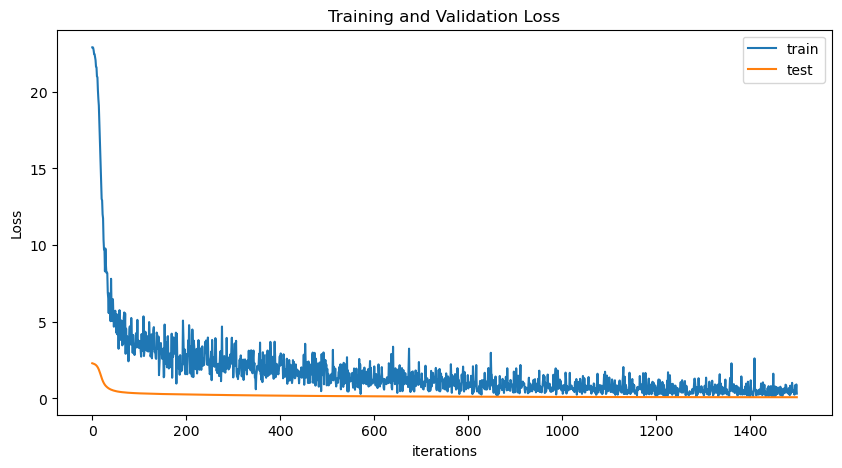

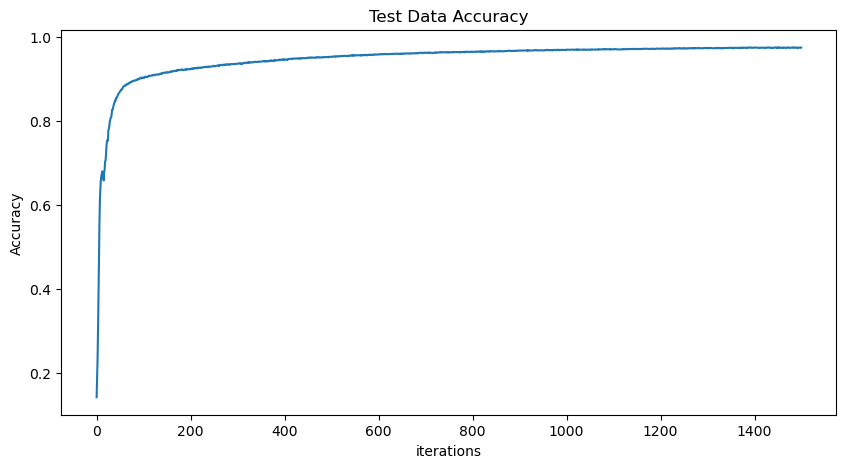

In [7]:

plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(losses_train,label="train")
plt.plot(losses_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('figs/FedAvg_Loss.png')
plt.show()

plt.figure(figsize=(10,5))
plt.title("Test Data Accuracy")
# plt.plot(acc_train,label="train")
plt.plot(acc_test,label="test")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.savefig('figs/FedAvg_Accuracy.png')
# plt.legend()
plt.show()

